<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        Final project for the <strong style="font-size: 26px;">Management and Analysis of Physics Datasets</strong> course<br>
        <strong style="font-size: 46px; display: block; margin-top: 20px;">Batch analysis of cosmic rays using Drift Tubes</strong>
    </h1>
</div>

<hr style="border: 1px solid #000;">

<div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="flex: 1; text-align: left;">
        <img src="./unipd_template.png" alt="Unipd template" width="500" style="margin-left: 50px;">
    </div>
    <div>
        <img src="./pod_template.png" alt="PoD template" width="350" style="margin-right: 50px;">
    </div>
</div>

<hr style="border: 1px solid #000;">

<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="flex: 1; text-align: left; font-size: 18px;">
        <!-- This space can remain empty if not needed -->
    </div>
    <div style="flex: 1; text-align: left; font-size: 18px; margin-left: 10px;">
        <p><strong style="font-size: 26px;">University of Padua - Department of Physics and Astronomy</strong></p>
        <p><strong>Degree course:</strong> Physics of Data</p>
        <p><strong>Course:</strong> Management and Analysis of Physics Datasets</p>
        <p><strong>Year:</strong> 2023-2024</p>
        <p><strong>Professor in charge:</strong> Jacopo Pazzini</p>
        <table style="margin: 0 auto; border-collapse: collapse; width: 80%; font-size: 16px;">
            <thead>
                <tr>
                    <th colspan="3" style="border: none; padding: 8px; text-align: center; font-weight: bold; font-size: 20px;">Students</th>
                </tr>
                <tr>
                    <th style="border: none; padding: 8px; text-align: left;">Name</th>
                    <th style="border: none; padding: 8px; text-align: left;">ID</th>
                    <th style="border: none; padding: 8px; text-align: left;">Email</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style="border: none; padding: 8px;">Ada D'Iorio</td>
                    <td style="border: none; padding: 8px;">2092320</td>
                    <td style="border: none; padding: 8px;">ada.diorio@studenti.unipd.it</td>
                </tr>
                <tr>
                    <td style="border: none; padding: 8px;">Dario Liotta</td>
                    <td style="border: none; padding: 8px;">2124229</td>
                    <td style="border: none; padding: 8px;">dario.liotta.1@studenti.unipd.it</td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


# Introduction

A set of muon detectors have been built and installed in Legnaro INFN Laboratories (∼$10 \ km$ far from Padova) and are currently used to collect signals from cosmic rays. The working principles of these detectors (named mini Drift Tubes or miniDTs) are based on ionization: charged particles traversing the volume of the detectors will ionize the gas mixture inside, thus producing electron-ion pairs. Specifically shaped electric fields make the electron cloud travel throughout the volume with an almost constant drift velocity ($v_{drift} = 53.8 \ \mu m/ns$). Near the sensing anode wire, the electric field intensifies, leading to additional ionization and avalanche effects, thereby amplifying the signal.

Signals generated by ionization events are collected on the anodic wire, then amplified, digitized, discriminated, and transmitted through a Data Acquisition (DAQ) system.

Within the DAQ system, a series of Field Programmable Gate Arrays (FPGAs) perform Time-to-Digital Conversion (TDC), associating a digital signal with each electron cloud based on the time of collection.
Each digitized signal is commonly referred to as a "hit" representing an ionization event within the detector.

<div style="text-align: center;">
    <img src="./Useful/muon-cell-schema.png" alt="Muon cell schema" width="500">
</div>

If the time of passage of the muon (usually referred to as $t_0$) is known, the TDC of a hit can be translated to a position inside the cell thanks to the constant $v_{drift}$, i.e:

$$ x_{hit} = (t_{hit}-t_0)v_{drift} $$

The time of passage of the muon is typically not known a priori and needs to be inferred from external information or geometrical considerations.
Additionally, there is an intrinsic left-right ambiguity associated with the time-to-space
conversion process. This means that the time information of a single hit is insufficient to
determine whether the muon passed through the right or left half of the cell.
To resolve this ambiguity and accurately reconstruct the trajectory of the muon, a full reconstruction of the track spanning multiple cells is required. By analyzing hits from multiple cells, it becomes possible to identify the track trajectory throughout one or more DT chambers and resolve the left-right ambiguity.




The geometry of one single detector (a miniDT “chamber”) is composed of $64$ cells arranged in $4$ layers of $16$ cells each. Adjacent layers are staggered by half of a cell width.

Each cell has a transversal dimension of $42\times13 \ mm^2$ (width × height). The schema for one DT chamber is reported in the following figure.

<div style="text-align: center;">
    <img src="./Useful/chamber-schema.png" alt="Chamber schema" width="1000">
</div>

Four DT chambers are stacked on top of each other in a "muon-telescope" configuration.

Three chambers (0, 2, 3) are oriented in the same direction, while the fourth (1) is rotated $90$ degrees to measure from an orthogonal view. Two external detectors (plastic scintillator palettes, shown in blue in the figure) provide the external timing information for the passage of particles, hence supplying the $t_0$ information.

## Task

Starting from the raw data collected by the DAQ of the detector, this project will require reconstructing the local and global track, relying on the external timing reference provided by the scintillator.

## Data structure

The raw dataset is provided on a cloud storage s3 bucket hosted on Cloud Veneto.
Name of the Bucket: mapd-minidt-batch
Link to visualize the list all contained files: https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/mapd-minidt-batch/

The dataset is composed of multiple binary files encoding the stream of hits collected:
1. Every hit is encoded as a 64 bit word;
2. Each word has the exact same structure;
3. The 64b data-format complies to the following standard:
- $0-4$   (5 bits)  $\rightarrow$ `TDC`;
- $5-16$  (12 bits) $\rightarrow$ `BX`;
- $17-48$ (32 bits) $\rightarrow$ `ORBIT`;
- $49-57$ (9 bits)  $\rightarrow$ `CHAN`;
- $58-60$ (3 bits)  $\rightarrow$ `FPGA`;
- $61-63$ (3 bits)  $\rightarrow$ `HEAD`.

The data should be "unpacked" from raw objects into a structured format (dataframe).

# Requirements

## Libraries

In [1]:
## Standard python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import re
import struct
import collections
import itertools
from itertools import combinations, product  
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

## PySpark library
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, array, lag, explode, count, first, last, desc, lit, atan
from pyspark.sql.functions import expr, row_number, format_number
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.functions import abs as abs_spark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, FloatType, DoubleType, ArrayType
from pyspark.sql import functions as F
from pyspark.sql.window import Window

## Mask credentials
import configparser

## Spark session

In [2]:
config = configparser.ConfigParser()
config.read('./aws_credentials.txt')
access_key = config.get('DEFAULT', 'access_key')
secret_key = config.get('DEFAULT', 'secret_key')

cores      = 4
memory     = "6000m"
partitions = 24

spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("MAPD B Project")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.4')\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')\
    .config("spark.executor.cores", cores)\
    .config("spark.executor.memory", memory)\
    .config("spark.sql.shuffle.partitions", partitions)\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', str(access_key))\
    .config('spark.hadoop.fs.s3a.secret.key', str(secret_key))\
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()



# Creating a spark context
sc = spark.sparkContext

# To ignore warning outputs
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/diorio/.ivy2/cache
The jars for the packages stored in: /home/diorio/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d7bfe847-8fd7-4ec9-afed-501c44bbc0ad;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 156ms :: artifacts dl 5ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------

## Benchmarking

In [3]:
'''
def get_nrun(cores, memory, partitions, directory):
    
    pattern = re.compile(rf"C{cores}-M{memory}-P{partitions}_Run-(\d+)\.txt")
    files = os.listdir(directory)
    matches = [int(m.group(1)) for f in files if (m := pattern.match(f))]

    if not matches:
        return 1
      
    return max(matches) + 1

nrun = get_nrun(cores, memory, partitions, "./Runs")
print(nrun)
'''

'\ndef get_nrun(cores, memory, partitions, directory):\n    \n    pattern = re.compile(rf"C{cores}-M{memory}-P{partitions}_Run-(\\d+)\\.txt")\n    files = os.listdir(directory)\n    matches = [int(m.group(1)) for f in files if (m := pattern.match(f))]\n\n    if not matches:\n        return 1\n      \n    return max(matches) + 1\n\nnrun = get_nrun(cores, memory, partitions, "./Runs")\nprint(nrun)\n'

In [4]:
'''
%cd "./Runs"

file_name = "C" + str(cores) + "-M" + memory + "-P" + str(partitions) + "_Run-" + str(nrun) + "-TEMPORARY.txt"
file = open(file_name, 'w')

def write_time(line):
    file.write(line + '\n')
'''

'\n%cd "./Runs"\n\nfile_name = "C" + str(cores) + "-M" + memory + "-P" + str(partitions) + "_Run-" + str(nrun) + "-TEMPORARY.txt"\nfile = open(file_name, \'w\')\n\ndef write_time(line):\n    file.write(line + \'\n\')\n'

In [5]:
'''
start_time = time.time()
'''

'\nstart_time = time.time()\n'

# Data import and inspection

## Data unpacking and conversion

We want to convert the raw binary object contained in the files into a structured form (a dataframe).

In [6]:
def unpack_data(data):
  word_format = 'Q'
  word = struct.unpack(word_format, data)[0]
    
  TDC   = word         & 0x1F
  BX    = (word >> 5)  & 0xFFF
  ORBIT = (word >> 17) & 0xFFFFFFFF
  CHAN  = (word >> 49) & 0x1FF
  FPGA  = (word >> 58) & 0x7
  HEAD  = (word >> 61) & 0x7
    
  return [TDC, BX, ORBIT, CHAN, FPGA, HEAD]



rdd  = sc.binaryRecords('s3a://mapd-minidt-batch/data_*.dat', 8)
rdd2 = rdd.map(unpack_data)

df = rdd2.toDF(["TDC", "BX", "ORBIT", "CHAN", "FPGA", "HEAD"])

The full and structured dataframe is shown below.

In [7]:
'''
df.show(10)
'''

'\ndf.show(10)\n'

In [8]:
'''
n = df.count()

print("Number of rows:", n)
'''

'\nn = df.count()\n\nprint("Number of rows:", n)\n'

In [9]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Dataset overall cleansing

We know that all entries other than those with `HEAD = 2` must be dropped.

In [10]:
df = df.filter(col("HEAD") == 2)
df = df.drop("HEAD")   # Since we don't need it anymore

df.show(10)

+---+----+----------+----+----+
|TDC|  BX|     ORBIT|CHAN|FPGA|
+---+----+----------+----+----+
|  2|2922|3387200947|  75|   0|
| 29|2227|3387200955| 105|   0|
|  7|2234|3387200955| 107|   0|
| 29| 476|3387200973| 126|   0|
| 12|1797|3387200955|  55|   1|
| 28|2165|3387200956|  36|   1|
| 14| 249|3387200970|  51|   1|
| 28| 475|3387200973|  90|   1|
| 16| 485|3387200973| 124|   0|
|  5| 480|3387200973| 127|   0|
+---+----+----------+----+----+
only showing top 10 rows



We now check if there is some data that is not in the expected range (so `FPGA` values other than $0$ and $1$ and `CHAN` values not in the $[0,128]$ range).

In [11]:
'''
df_not_in_range = df.filter((col('CHAN') > 128) | (col('FPGA') > 1))

df_not_in_range.groupBy('FPGA').count().show()
df_not_in_range.groupBy('CHAN').count().show()
'''

"\ndf_not_in_range = df.filter((col('CHAN') > 128) | (col('FPGA') > 1))\n\ndf_not_in_range.groupBy('FPGA').count().show()\ndf_not_in_range.groupBy('CHAN').count().show()\n"

We can see that there are some outsiders inside the `CHAN` attribute, all equal to $138$, which we can drop.

In [12]:
df = df.filter(col('CHAN') != 138)

In [13]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Muon passages

We know that muon passages are associated with the attributes `CHAN = 128` and simultaneously `FPGA = 1`, so we create another attribute called `SCINT`, equal to $1$ if these conditions are met, and equal to $0$ if they are not, which tells us whether the scintillator has detected the passage of a muon.

In [14]:
df = df.withColumn('SCINT', when((col('CHAN') == 128) & (col('FPGA') == 1), 1).otherwise(0))

Now that we have the scintillator information, we can now count how many scintillation events are there per orbit. Hence, we inspect the number of hits and the number of scintillator hits for each orbit.

In [15]:
'''
n_hits = df.groupby('ORBIT')\
           .count()

bins, counts = n_hits.select('count')\
                     .rdd\
                     .histogram(list(np.arange(0, 80, 1)))

plt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.title('Counts per orbit')
plt.show()
'''

"\nn_hits = df.groupby('ORBIT')           .count()\n\nbins, counts = n_hits.select('count')                     .rdd                     .histogram(list(np.arange(0, 80, 1)))\n\nplt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')\nplt.xlabel('Hits')\nplt.ylabel('Counts')\nplt.title('Counts per orbit')\nplt.show()\n"

In [16]:
'''
data_counts = df.groupby('ORBIT')\
                .agg(F.sum('SCINT').alias('n_scint'))

scint_counts = data_counts.select('n_scint').rdd.flatMap(lambda x: x).countByValue()
sorted_counts = sorted(scint_counts.items())
x, y = zip(*sorted_counts)

plt.bar(x, y, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.title('Scintillator counts per orbit')
plt.yscale('log')
plt.show()
'''

"\ndata_counts = df.groupby('ORBIT')                .agg(F.sum('SCINT').alias('n_scint'))\n\nscint_counts = data_counts.select('n_scint').rdd.flatMap(lambda x: x).countByValue()\nsorted_counts = sorted(scint_counts.items())\nx, y = zip(*sorted_counts)\n\nplt.bar(x, y, edgecolor = 'black')\nplt.xlabel('Hits')\nplt.ylabel('Counts')\nplt.title('Scintillator counts per orbit')\nplt.yscale('log')\nplt.show()\n"

Unfortunately, as you can see from the second plot, there is a lot of noise caused by the passage of muons or other particles that have not travelled inside the scintillators. In order to detect and analyse the particle tracks, we need to filter the data further.

First of all, we drop all the hits within an orbit that does not contain a scintillation event.

In [17]:
orbits_w_scint = df.filter(col('SCINT') == 1).select('ORBIT')
df = df.join(orbits_w_scint, 'ORBIT', 'inner')

To further investigate the noise, we need to search for finer time intervals. To do this, we first need to evaluate the absolute hit time information.

In [18]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Hit time information

Time information is provided by three attributes: 'ORBIT', 'BX' and 'TDC'. We can evaluate the absolute time associated with each hit in nanoseconds using the formula

$$t_{abs} = 25\cdot\left(\texttt{ORBIT} * 3564 + \texttt{BX} + \texttt{TDC}/30\right)$$

In [19]:
df = df.withColumn("T_ABS", 25 * (col("ORBIT") * 3564 + col("BX") + col("TDC") / 30))
df = df.drop("ORBIT", "BX", "TDC")   # Since we don't need them anymore

In order to compare the time of the chamber hits with the time of the scintillation events, we have to take into account the estimated offset based on the chamber hit. Therefore, we evaluate two spatial coordinates associated with each hit: the `CHAMBER`, which goes from $0$ to $3$ from bottom to top, and the `LAYER`, which goes from $1$ to $4$ from top to bottom.

In [20]:
# Chamber information
df = df.withColumn('CHAMBER',
                   when((col('FPGA') == 0) & (col('CHAN') >= 0) & (col('CHAN') <= 63), 0)
                   .when((col('FPGA') == 0) & (col('CHAN') >= 64) & (col('CHAN') <= 127), 1)
                   .when((col('FPGA') == 1) & (col('CHAN') >= 0) & (col('CHAN') <= 63), 2)
                   .when((col('FPGA') == 1) & (col('CHAN') >= 64) & (col('CHAN') <= 127), 3)
                   .otherwise(-1))

# Layer information 
df = df.withColumn('LAYER',
                   when(col('CHAN') % 4 == 0, 1)
                    .when(col('CHAN') % 4 == 2, 2)
                    .when(col('CHAN') % 4 == 1, 3)
                    .when(col('CHAN') % 4 == 3, 4)
                    .otherwise(-1))
df = df.withColumn('LAYER', when(col('CHAMBER') == -1, -1).otherwise(col('LAYER')))

df.show(10)

+----+----+-----+--------------------+-------+-----+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|
+----+----+-----+--------------------+-------+-----+
| 128|   1|    1|9.473750181575001E11|     -1|   -1|
|  16|   0|    0|   9.473750180975E11|      0|    1|
|  15|   0|    0|9.473750181908333E11|      0|    4|
| 113|   0|    0|9.473750181991666E11|      1|    3|
|  17|   0|    0|9.473750182541666E11|      0|    3|
| 110|   0|    0|9.473750182966667E11|      1|    2|
|  41|   1|    0|9.473750182366666E11|      2|    3|
|  42|   1|    0|   9.473750182025E11|      2|    2|
|  43|   1|    0|9.473750183691667E11|      2|    4|
|  40|   1|    0|9.473750184049999E11|      2|    1|
+----+----+-----+--------------------+-------+-----+
only showing top 10 rows



We are now able to remove the offset.

In [21]:
df = df.withColumn('OFFSET', 
                   when(col('CHAMBER') == 0, 95.0 - 1.1)
                   .when(col('CHAMBER') == 1, 95.0 + 6.4)
                   .when(col('CHAMBER') == 2, 95.0 + 0.5)
                   .when(col('CHAMBER') == 3, 95.0 - 2.6)
                   .otherwise(0.0))

df = df.withColumn("T_ABS", col("T_ABS") + (col("OFFSET")))\
       .drop('OFFSET')

df.show(10)

+----+----+-----+--------------------+-------+-----+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|
+----+----+-----+--------------------+-------+-----+
|  43|   1|    0|5.685584407213334E11|      2|    4|
| 118|   1|    0|5.685584406465668E11|      3|    2|
| 128|   1|    1|   5.685584405825E11|     -1|   -1|
|  44|   1|    0|5.685584407438334E11|      2|    1|
| 119|   1|    0|   5.685584406024E11|      3|    4|
|  45|   1|    0|   5.685584408205E11|      2|    3|
| 120|   1|    0|5.685584408640667E11|      3|    1|
| 117|   0|    0|5.685584406272334E11|      1|    3|
| 116|   0|    0|5.685584407047334E11|      1|    1|
| 119|   0|    0|5.685584408922334E11|      1|    4|
+----+----+-----+--------------------+-------+-----+
only showing top 10 rows



Now we have all the temporal information we need. One thing we can evaluate is the minimum and maximum absolute time for a hit in the data.

In [22]:
'''
min_t_abs = df.agg(F.min(F.col('T_ABS'))).collect()[0][0]
max_t_abs = df.agg(F.max(F.col('T_ABS'))).collect()[0][0]

print("Minimum absolute time:", min_t_abs)
print("Maximum absolute time:", max_t_abs)
'''

'\nmin_t_abs = df.agg(F.min(F.col(\'T_ABS\'))).collect()[0][0]\nmax_t_abs = df.agg(F.max(F.col(\'T_ABS\'))).collect()[0][0]\n\nprint("Minimum absolute time:", min_t_abs)\nprint("Maximum absolute time:", max_t_abs)\n'

Let's look at the histogram associated with the absolute time.

In [23]:
'''
bins, counts = df.select('T_ABS')\
                 .rdd\
                 .histogram(list(np.arange(5.5E10, 3.5E13, 3.5E11)))   # Approximately 100 bins

plt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')
plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('Histogram of the absolute time')
plt.show()
'''

"\nbins, counts = df.select('T_ABS')                 .rdd                 .histogram(list(np.arange(5.5E10, 3.5E13, 3.5E11)))   # Approximately 100 bins\n\nplt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')\nplt.xlabel('Time (ns)')\nplt.ylabel('Counts')\nplt.title('Histogram of the absolute time')\nplt.show()\n"

We can clearly see some spikes and some low counts, but on average the number of measurements is pretty consistent.

In [24]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Scintillation intervals

Knowing the geometrical structure of the detector, we can make some physical considerations; in fact, each cell has a width equal to $42 \ mm$, and each muon passage is revealed via ionisation, i.e. an electron moving inside the cell from the cathode (at the edge) to the anode wire (at the centre) with a constant velocity $v_{drift}$. Since we know the maximum distance that electrons can travel (half the cell width, $21 \ mm$), and we also know $v_{drift}$, we can estimate the maximum time for which a hit can be causally related to a scintillation event:

$$t_{max}=\frac{\frac{w}{2}}{v_{drift}}=\frac{21\cdot10^3 \ \mu m}{53.8 \ \frac{\mu m}{ns}}\simeq390.33 \ ns$$

This means that any hit more than $390 \ ns$ away in time cannot be related to a muon transition and we can discard it.

First we create a new attribute called `INTERVAL` in which we enumerate the scintillation events.

In [25]:
windowSpec = Window.partitionBy(when(col("SCINT") == 1, 1).otherwise(0)).orderBy("T_ABS")

df = df.withColumn("is_scint", col("SCINT") == 1)\
       .withColumn("INTERVAL", when(col("is_scint"), row_number().over(windowSpec))\
       .otherwise(-1))\
       .drop("is_scint")

df.filter(col('SCINT') == 1).orderBy("T_ABS").show(10)

+----+----+-----+--------------------+-------+-----+--------+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|INTERVAL|
+----+----+-----+--------------------+-------+-----+--------+
| 128|   1|    1|    5.93687594025E10|     -1|   -1|       1|
| 128|   1|    1|9.969828883083333E10|     -1|   -1|       2|
| 128|   1|    1|1.000643437983333...|     -1|   -1|       3|
| 128|   1|    1|1.001737480608333...|     -1|   -1|       4|
| 128|   1|    1|    1.00411033115E11|     -1|   -1|       5|
| 128|   1|    1|   1.007348098925E11|     -1|   -1|       6|
| 128|   1|    1|1.011551253333333...|     -1|   -1|       7|
| 128|   1|    1|1.020050790808333...|     -1|   -1|       8|
| 128|   1|    1|   1.025400410475E11|     -1|   -1|       9|
| 128|   1|    1|1.025839947391666...|     -1|   -1|      10|
+----+----+-----+--------------------+-------+-----+--------+
only showing top 10 rows



We now evaluate the temporal distance between consecutive scintillation events, because all events within $390\times2 \ ns=780 \ ns$ should be dropped, otherwise there is a possibility that we would not know which scintillation event a hit belongs to.

In [26]:
windowSpec = Window.partitionBy("SCINT").orderBy("T_ABS")

df = df.withColumn("T_DIFF", when(col("SCINT") == 1, col("T_ABS") - lag("T_ABS")\
       .over(windowSpec))\
       .otherwise(-1))

df.filter(col('SCINT') == 1).orderBy("T_ABS").show(10)

+----+----+-----+--------------------+-------+-----+--------+--------------------+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|INTERVAL|              T_DIFF|
+----+----+-----+--------------------+-------+-----+--------+--------------------+
| 128|   1|    1|    5.93687594025E10|     -1|   -1|       1|                NULL|
| 128|   1|    1|9.969828883083333E10|     -1|   -1|       2|4.032952942833333E10|
| 128|   1|    1|1.000643437983333...|     -1|   -1|       3|       3.660549675E8|
| 128|   1|    1|1.001737480608333...|     -1|   -1|       4|       1.094042625E8|
| 128|   1|    1|    1.00411033115E11|     -1|   -1|       5|2.3728505416667175E8|
| 128|   1|    1|   1.007348098925E11|     -1|   -1|       6|       3.237767775E8|
| 128|   1|    1|1.011551253333333...|     -1|   -1|       7| 4.203154408333435E8|
| 128|   1|    1|1.020050790808333...|     -1|   -1|       8| 8.499537474999847E8|
| 128|   1|    1|   1.025400410475E11|     -1|   -1|       9|5.3496196666667175E8|
| 12

What we could do now is to filter out all the rows where `SCINT == 1` and `T_DIFF <= 780`. The problem is that we would not be filtering in the right way. Let's look at the following example:

```bash

|   T_DIFF   |
+------------+
|   123456789|
|         400|
|         250|

```

If we just filter with `T_DIFF <= 780`, only the last two lines will be deleted. Instead, we want to delete the first row as well, since it's still $400 \ ns$ away from the next event. To do this, we create another column called `T_DIFF2`, which is the same as `T_DIFF` but shifted up one value where `SCINT=1`. Looking at the same example, we would have

```bash

|   T_DIFF   |   T_DIFF2   |
+------------+-------------+
|   123456789|          400|
|         400|          250|
|         250|         NULL|

```

In this way, we would correctly drop lines if we apply the same filter to both `T_DIFF` and `T_DIFF2`.

In [27]:
windowSpec = Window.partitionBy(when(col("SCINT") == 1, 1).otherwise(0)).orderBy("T_ABS")

# Since we don't want to drop off first and last scint event, where T_DIFF and T_DIFF2 are NULL, we fill NA values with 781

t_max = 390

df = df.withColumn("T_DIFF2", F.lead("T_DIFF").over(windowSpec))\
       .fillna(t_max * 2 + 1)\
       .filter(~((col("SCINT") == 1) & ((col("T_DIFF") <= t_max * 2) | (col("T_DIFF2") <= t_max * 2))))\
       .drop("T_DIFF", "T_DIFF2")   # Since we don't need them anymore

df.show(10)

+----+----+-----+--------------------+-------+-----+--------+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|INTERVAL|
+----+----+-----+--------------------+-------+-----+--------+
|  98|   0|    0|5.936875943139999...|      1|    2|      -1|
|  36|   0|    0|5.936875943223334E10|      0|    1|      -1|
|  37|   0|    0|5.936875943306666...|      0|    3|      -1|
| 102|   0|    0|5.936875944556667E10|      1|    2|      -1|
| 101|   1|    0|5.936875946073333E10|      3|    3|      -1|
|  40|   0|    0|5.936875946806666...|      0|    1|      -1|
| 100|   1|    0|5.936875947156666...|      3|    1|      -1|
|  41|   0|    0|    5.93687594814E10|      0|    3|      -1|
|  36|   1|    0|5.936875948883333E10|      2|    1|      -1|
|  99|   0|    0|    5.93687594889E10|      1|    4|      -1|
+----+----+-----+--------------------+-------+-----+--------+
only showing top 10 rows



Now it's time to assign each hit to its scintillation event. From our previous work, we can say two things:

1. Each hit can be associated with at most one scintillation event, since we deleted all events within the $780 \ ns$ time window.
2. Because of the previous point, if we order the dataframe in ascending order with respect to `T_ABS`, a hit can be associated with either the previous or the following scintillation event.

We now create two more attributes, called `T_ABS_PREV` and `T_ABS_FOLL`, which contain the difference between the `T_ABS` of the hit and the `T_ABS` of the previous and the following event respectively.

In [28]:
windowSpecAsc = Window.orderBy("T_ABS")
windowSpecDesc = Window.orderBy(desc("T_ABS"))

df = df.withColumn("T_ABS_PREV_SCINT1", when(col("SCINT") == 1, col("T_ABS")))\
       .withColumn("T_PREV", when(col("SCINT") == 0, last("T_ABS_PREV_SCINT1", True).over(windowSpecAsc)))\
       .withColumn("T_ABS_PREV", when(col("SCINT") == 0, abs_spark(col("T_ABS") - col("T_PREV"))))\
       .drop("T_ABS_PREV_SCINT1", "T_PREV")

df = df.withColumn("T_ABS_FOLL_SCINT1", when(col("SCINT") == 1, col("T_ABS")))\
       .withColumn("T_FOLL", when(col("SCINT") == 0, last("T_ABS_FOLL_SCINT1", True).over(windowSpecDesc)))\
       .withColumn("T_ABS_FOLL", when(col("SCINT") == 0, abs_spark(col("T_ABS") - col("T_FOLL"))))\
       .drop("T_ABS_FOLL_SCINT1", "T_FOLL")

df.show(10)

+----+----+-----+--------------------+-------+-----+--------+------------+----------+
|CHAN|FPGA|SCINT|               T_ABS|CHAMBER|LAYER|INTERVAL|  T_ABS_PREV|T_ABS_FOLL|
+----+----+-----+--------------------+-------+-----+--------+------------+----------+
| 120|   0|    0|3.494860100189140...|      1|    1|      -1| 305.5703125|      NULL|
|  49|   1|    0|3.494860100187966...|      2|    3|      -1| 293.8359375|      NULL|
| 125|   1|    0|3.494860100187739...|      3|    3|      -1|    291.5625|      NULL|
|  48|   1|    0|3.494860100187633...|      2|    1|      -1|290.50390625|      NULL|
| 124|   1|    0|3.494860100179573E13|      3|    1|      -1| 209.8984375|      NULL|
| 122|   1|    0| 3.49486010017249E13|      3|    2|      -1|139.06640625|      NULL|
|  46|   1|    0|3.494860100165549...|      2|    2|      -1|  69.6640625|      NULL|
| 123|   0|    0|3.494860100165056...|      1|    4|      -1| 64.73046875|      NULL|
| 122|   0|    0| 3.49486010016464E13|      1|    2|  

For computational purposes, we replace the $-1$ values in `INTERVAL` with $NULL$ values.

In [29]:
df = df.withColumn("INTERVAL", when(col("INTERVAL") == -1, None).otherwise(col("INTERVAL")))

If a value between `T_ABS_PREV` and `T_ABS_FOLL` is less than or equal to $390$, we associate that hit with the respective event. We also store this time difference in a new column called `T_DIFF`, which also sets all scintillation events to $0$.

In [30]:
df = df.withColumn("INTERVAL", when(((col("SCINT") == 0) & (col("T_ABS_PREV") <= 390)), last("INTERVAL", True).over(windowSpecAsc))\
                    .otherwise(col("INTERVAL")))
df = df.withColumn("INTERVAL", when(((col("SCINT") == 0) & (col("T_ABS_FOLL") <= 390)), last("INTERVAL", True).over(windowSpecDesc))\
                    .otherwise(col("INTERVAL")))

df = df.withColumn("T_DIFF", when(((col("SCINT") == 0) & (col("T_ABS_PREV") <= 390)), col("T_ABS_PREV")))
df = df.withColumn("T_DIFF", when(((col("SCINT") == 0) & (col("T_ABS_FOLL") <= 390)), col("T_ABS_FOLL"))\
                    .otherwise(col("T_DIFF")))
df = df.na.fill(value = 0, subset = ["T_DIFF"])

We now drop the columns `T_ABS`, `T_ABS_PREV` and `T_ABS_FOLL`. Also, any $NULL$ value in the `T_DIFF` attribute means that a hit is not associated with any event, so we can drop those as well.

In [31]:
df = df.drop("T_ABS", "T_ABS_PREV", "T_ABS_FOLL")
df = df.dropna()

df.show(10)

+----+----+-----+-------+-----+--------+------------+
|CHAN|FPGA|SCINT|CHAMBER|LAYER|INTERVAL|      T_DIFF|
+----+----+-----+-------+-----+--------+------------+
| 120|   0|    0|      1|    1|   53882| 305.5703125|
|  49|   1|    0|      2|    3|   53882| 293.8359375|
| 125|   1|    0|      3|    3|   53882|    291.5625|
|  48|   1|    0|      2|    1|   53882|290.50390625|
| 124|   1|    0|      3|    1|   53882| 209.8984375|
| 122|   1|    0|      3|    2|   53882|139.06640625|
|  46|   1|    0|      2|    2|   53882|  69.6640625|
| 123|   0|    0|      1|    4|   53882| 64.73046875|
| 122|   0|    0|      1|    2|   53882| 60.56640625|
|  47|   1|    0|      2|    4|   53882|  32.1640625|
+----+----+-----+-------+-----+--------+------------+
only showing top 10 rows



In this way, our dataset contains all the events that we consider valid.

Before proceeding to the next section, we can examine the distributions of the `T_DIFF` attribute, which we know ranges from $0$ to $390$.

In [32]:
'''
bins, counts = df.select('T_DIFF')\
                 .rdd\
                 .histogram(list(np.arange(0, 390, 5)))

plt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')
plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('Histogram of the absolute time difference')
plt.show()
'''

"\nbins, counts = df.select('T_DIFF')                 .rdd                 .histogram(list(np.arange(0, 390, 5)))\n\nplt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')\nplt.xlabel('Time (ns)')\nplt.ylabel('Counts')\nplt.title('Histogram of the absolute time difference')\nplt.show()\n"

The average frequency is constant around $10^4$, with the only exeption of the first bins ($0-15 \ ns$ range) with far fewer counts (approximately one order of magnitude less).

In this way we filtered our dataset using time information, but we can still filter out some data from a spatial point of view.

In [33]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Spatial perspective

In this section we are interested in analysing the spatial distribution of the muons before starting to reconstruct the tracks.

One thing we can look at is the distribution of hits per layer, to see if there is a "preferred" layer or chamber in the muon passages.

In [34]:
'''
freqs = df.groupby('CHAMBER', 'LAYER')\
          .count()\
          .withColumn('LABEL', F.concat(col('CHAMBER'), F.lit('-'), col('LAYER')))\
          .orderBy('CHAMBER', 'LAYER')\
          .withColumn("index", row_number().over(Window.orderBy('CHAMBER', 'LAYER')))\
          .toPandas()
'''

'\nfreqs = df.groupby(\'CHAMBER\', \'LAYER\')          .count()          .withColumn(\'LABEL\', F.concat(col(\'CHAMBER\'), F.lit(\'-\'), col(\'LAYER\')))          .orderBy(\'CHAMBER\', \'LAYER\')          .withColumn("index", row_number().over(Window.orderBy(\'CHAMBER\', \'LAYER\')))          .toPandas()\n'

In [35]:
'''
labels = []
colors = []

bars_per_group = 4

for i, row in freqs.iterrows():
    labels.append(f"{row['CHAMBER']}-{row['LAYER']}")
    colors.append(plt.cm.tab10(row['LAYER']))
    
    # Creating spaces between chambers for a better visualization
    if (i+1) % bars_per_group == 0:
        labels.append(' ' * i)
        colors.append('white')

frequencies = np.array(freqs['count'], dtype = float)
frequencies = np.insert(frequencies, np.array([4, 8, 12, 16]), np.nan)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, frequencies, color = colors, edgecolor = 'black', width = 0.8)
ax.set_xlabel('Chamber-Layer Combination')
ax.set_ylabel('Frequency')
ax.set_title('Hit frequency per Chamber-Layer combination')
plt.xticks(rotation=45)
plt.tight_layout()


# Legend
unique_layers  = sorted(freqs['LAYER'].unique())
legend_labels  = [f'Layer {layer}' for layer in unique_layers]
legend_handles = [plt.Rectangle((0,0),1,1, color = plt.cm.tab10(layer)) for layer in unique_layers]
plt.legend(legend_handles, legend_labels, loc = 'upper left')

plt.show()
'''

'\nlabels = []\ncolors = []\n\nbars_per_group = 4\n\nfor i, row in freqs.iterrows():\n    labels.append(f"{row[\'CHAMBER\']}-{row[\'LAYER\']}")\n    colors.append(plt.cm.tab10(row[\'LAYER\']))\n    \n    # Creating spaces between chambers for a better visualization\n    if (i+1) % bars_per_group == 0:\n        labels.append(\' \' * i)\n        colors.append(\'white\')\n\nfrequencies = np.array(freqs[\'count\'], dtype = float)\nfrequencies = np.insert(frequencies, np.array([4, 8, 12, 16]), np.nan)\n\n# Plot\nfig, ax = plt.subplots(figsize=(12, 6))\nbars = ax.bar(labels, frequencies, color = colors, edgecolor = \'black\', width = 0.8)\nax.set_xlabel(\'Chamber-Layer Combination\')\nax.set_ylabel(\'Frequency\')\nax.set_title(\'Hit frequency per Chamber-Layer combination\')\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n\n# Legend\nunique_layers  = sorted(freqs[\'LAYER\'].unique())\nlegend_labels  = [f\'Layer {layer}\' for layer in unique_layers]\nlegend_handles = [plt.Rectangle((0,0),1,1,

On average, the $1$ and $2$ chambers have twice the counts of the $0$ and $3$ chambers. This is probably due to the fact that the formers are placed between the two scintillators where the muon passages are registered, so - given the flux of muons coming from space - it's more likely that the muons will pass through them and cross the scintillators at the same time. However, this reasoning should only explain the lack of hits in chamber $3$ and not in chamber $0$. We think that the different orientation of chamber $1$ may cause the registration of some tracks that don't cross any cell of chamber $0$.

Another way of looking at this result is to consider the cumulative sum of hits divided by chamber with respect to the interval index.

In [36]:
'''
n_hits = df.groupBy('INTERVAL').count()

n_per_interval_and_chamber = df.groupBy('INTERVAL', 'CHAMBER')\
                               .agg(F.count('*').alias("CHAMBER_COUNT"))\
                               .orderBy('INTERVAL', 'CHAMBER')

windowSpec = Window.partitionBy('CHAMBER').orderBy('INTERVAL')
n_per_interval_and_chamber = n_per_interval_and_chamber.withColumn(
    'CUMULATIVE_CHAMBERS', 
    F.sum('CHAMBER_COUNT').over(windowSpec)
)

windowSpec = Window.orderBy('INTERVAL')
n_hits = n_hits.withColumn(
    'CUMULATIVE_COUNT', 
    F.sum('count').over(windowSpec)
)

n_chambers_data = n_per_interval_and_chamber.select('INTERVAL', 'CHAMBER', 'CUMULATIVE_CHAMBERS').rdd
n_hits_data = n_hits.select('INTERVAL', 'CUMULATIVE_COUNT').rdd

n_chambers_list = n_chambers_data.map(lambda row: (row['INTERVAL'], row['CHAMBER'], row['CUMULATIVE_CHAMBERS'])).collect()
n_hits_list = n_hits_data.map(lambda row: (row['INTERVAL'], row['CUMULATIVE_COUNT'])).collect()

orbits_chambers = sorted(set(row[0] for row in n_chambers_list))
chamber_data = {chamber: [] for chamber in set(row[1] for row in n_chambers_list)}

for orbit, chamber, cumulative_chambers in n_chambers_list:
    chamber_data[chamber].append((orbit, cumulative_chambers))

for chamber, data in chamber_data.items():
    data_subset = sorted(data)
    orbits, cumulative_chambers = zip(*data_subset)
    plt.plot(orbits, cumulative_chambers, marker='.', markersize=0.5, linewidth=1, alpha=0.8, label=f'Chamber {chamber}')

# Plot
n_hits = sorted(n_hits_list)
orbits_hits, cumulative_counts = zip(*n_hits)

plt.plot(orbits_hits, cumulative_counts, marker='.', markersize=0.5, linewidth=1, color='black', label='Total sum')
plt.title('Cumulative number of Counts per interval and chamber')
plt.xlabel('Interval')
plt.ylabel('Cumulative number of counts')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nn_hits = df.groupBy(\'INTERVAL\').count()\n\nn_per_interval_and_chamber = df.groupBy(\'INTERVAL\', \'CHAMBER\')                               .agg(F.count(\'*\').alias("CHAMBER_COUNT"))                               .orderBy(\'INTERVAL\', \'CHAMBER\')\n\nwindowSpec = Window.partitionBy(\'CHAMBER\').orderBy(\'INTERVAL\')\nn_per_interval_and_chamber = n_per_interval_and_chamber.withColumn(\n    \'CUMULATIVE_CHAMBERS\', \n    F.sum(\'CHAMBER_COUNT\').over(windowSpec)\n)\n\nwindowSpec = Window.orderBy(\'INTERVAL\')\nn_hits = n_hits.withColumn(\n    \'CUMULATIVE_COUNT\', \n    F.sum(\'count\').over(windowSpec)\n)\n\nn_chambers_data = n_per_interval_and_chamber.select(\'INTERVAL\', \'CHAMBER\', \'CUMULATIVE_CHAMBERS\').rdd\nn_hits_data = n_hits.select(\'INTERVAL\', \'CUMULATIVE_COUNT\').rdd\n\nn_chambers_list = n_chambers_data.map(lambda row: (row[\'INTERVAL\'], row[\'CHAMBER\'], row[\'CUMULATIVE_CHAMBERS\'])).collect()\nn_hits_list = n_hits_data.map(lambda row: (row[\'INTERVAL\'], row[\'

We now want to analyse the "frontal" perspective of the experiment. To do this, we have created a function called `get_section()`, which divides each layer into $16$ sections. We expect a higher number of counts in the sections closest to the scintillator.

In [37]:
'''
def get_section(chamber, chan):

    block1 = [i for i in range(0, 64)] 
    block2 = [i for i in range(64, 128)]

    sub_lists1 = [block1[i:i + 4] for i in range(0, len(block1), 4)]
    sub_lists2 = [block2[i:i + 4] for i in range(0, len(block2), 4)]

    
    if chamber == 0 or chamber == 2:
         section = next((index for index, sublist in enumerate(sub_lists1) if chan in sublist), -1)
         
    elif chamber == 1 or chamber == 3:
         section = next((index for index, sublist in enumerate(sub_lists2) if chan in sublist), -1)

    return(section)
'''

'\ndef get_section(chamber, chan):\n\n    block1 = [i for i in range(0, 64)] \n    block2 = [i for i in range(64, 128)]\n\n    sub_lists1 = [block1[i:i + 4] for i in range(0, len(block1), 4)]\n    sub_lists2 = [block2[i:i + 4] for i in range(0, len(block2), 4)]\n\n    \n    if chamber == 0 or chamber == 2:\n         section = next((index for index, sublist in enumerate(sub_lists1) if chan in sublist), -1)\n         \n    elif chamber == 1 or chamber == 3:\n         section = next((index for index, sublist in enumerate(sub_lists2) if chan in sublist), -1)\n\n    return(section)\n'

We now plot the histogram of counts per section. Because of the different orientation of chamber $1$, we will also consider the case where these hits are excluded from the counts.

In [38]:
'''
def view_sections(event, sections, title = 'Counts per section', flag = True):
   
    sections_cleaned = [x if not np.isnan(x) else -2 for x in sections]
    
    # Count occurrences manually
    occurrences = {}
    for section in sections_cleaned:
        if section in occurrences:
            occurrences[section] += 1
        else:
            occurrences[section] = 1
    elements = sorted(occurrences.keys())
    
    counts = [occurrences[element] for element in elements]
   
    # Plotting only the histogram
    if flag == False:
      fig, ax = plt.subplots(1, 1, figsize = (10, 5))
      ax.bar(elements, counts, edgecolor = 'black')
      ax.set_xlabel('Section')
      ax.set_ylabel('Counts')
      ax.set_title(title)
      ax.set_xticks([i for i in range(0, len(elements))])
      ax.set_xlim(-1, len(elements))
      ax.tick_params(axis = 'x', rotation = 45)
      plt.show() 

    # Plotting both the histogram and the schema
    else:
        # Histogram
        fig, ax = plt.subplots(2, 1, figsize=(10, 10))     
        ax[0].bar(elements, counts, edgecolor = 'black')
        ax[0].set_xlabel('Section')
        ax[0].set_ylabel('Counts')
        ax[0].set_title(title)
        ax[0].set_xticks([i for i in range(0, len(elements))])
        ax[0].set_xlim(-1, len(elements))
        ax[0].tick_params(axis = 'x', rotation = 45)

        # Schema

        # Parameters
        w, h = 1, 13/42
        x_rect = np.arange(-8*w, 8*w, w)
        z_rect = np.arange(-2*h, 2*h, h)
        base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
        colors = [to_rgba(c, alpha=0.5) for c in base_colors] 
        scintillator_height = 0.3
        scintillator_y = -3.75*h - scintillator_height/2
        scintillator_x_start = 0.5*w + 7.5 + 0.20
        scintillator_width = 4.5*w - 0.5 - 0.20

        # Drawning
        ax[1].set_xlim(-9*w, 9*w)
        ax[1].set_ylim(-2*h, 2*h)
        counter = 0
        for i in range(4):
            if i % 2 == 0:
                x = x_rect + w/2 + 7
            else:
                x = x_rect + 7
            for j in range(16):
                if counter <= 15:
                   ax[1].add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j], label = f'Section {j}'))
                else:
                   ax[1].add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j]))
                counter += 1

        ax[1].add_patch(Rectangle((scintillator_x_start, scintillator_y), scintillator_width, scintillator_height,
                              lw=2, edgecolor='blue', facecolor='lightblue', alpha=0.5, hatch='/', label = 'Scintillator'))
        ax[1].axis('equal')
        ax[1].set_xticks([i for i in range(16)])
        ax[1].set_title('Experimental apparatus')


        # Legend
        legend = ax[1].legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True, shadow = True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(0.8)
        plt.setp(legend.get_texts(), color = 'black') 
    
        plt.tight_layout()
        plt.show()
'''

"\ndef view_sections(event, sections, title = 'Counts per section', flag = True):\n   \n    sections_cleaned = [x if not np.isnan(x) else -2 for x in sections]\n    \n    # Count occurrences manually\n    occurrences = {}\n    for section in sections_cleaned:\n        if section in occurrences:\n            occurrences[section] += 1\n        else:\n            occurrences[section] = 1\n    elements = sorted(occurrences.keys())\n    \n    counts = [occurrences[element] for element in elements]\n   \n    # Plotting only the histogram\n    if flag == False:\n      fig, ax = plt.subplots(1, 1, figsize = (10, 5))\n      ax.bar(elements, counts, edgecolor = 'black')\n      ax.set_xlabel('Section')\n      ax.set_ylabel('Counts')\n      ax.set_title(title)\n      ax.set_xticks([i for i in range(0, len(elements))])\n      ax.set_xlim(-1, len(elements))\n      ax.tick_params(axis = 'x', rotation = 45)\n      plt.show() \n\n    # Plotting both the histogram and the schema\n    else:\n        # Hi

In [39]:
'''
sections = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()
sections = np.array(sections).flatten()

df_wo_chamber1       = df.filter(col('CHAMBER') != 1)
sections_wo_chamber1 = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()
sections_wo_chamber1 = np.array(sections_wo_chamber1).flatten()

view_sections(df_wo_chamber1, sections_wo_chamber1, title = 'Counts per section without chamber 1', flag = False)
view_sections(df, sections, flag = True)
'''

"\nsections = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()\nsections = np.array(sections).flatten()\n\ndf_wo_chamber1       = df.filter(col('CHAMBER') != 1)\nsections_wo_chamber1 = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()\nsections_wo_chamber1 = np.array(sections_wo_chamber1).flatten()\n\nview_sections(df_wo_chamber1, sections_wo_chamber1, title = 'Counts per section without chamber 1', flag = False)\nview_sections(df, sections, flag = True)\n"

Results reflect our expectations. Also, the absence of chamber $1$ hits does not appear to make a real difference.

In [40]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Layer cleansing

To further investigate noise, we want to see if, given the spatial information we have, we can exclude some events on the assumption that they're all noise, or at least contaminated with some noise. To do this, we create a new attribute called `SECTION`, which assigns to each hit a number between $0$ and $15$, as already done in the frontal spatial perspective plot with the function `get_section()`; for clarity, we show the complete scheme below.

In [41]:
'''
w, h = 1, 13/42
x_rect = np.arange(-8*w, 8*w, w)
z_rect = np.arange(-2*h, 2*h, h)
base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
colors = [to_rgba(c, alpha=0.5) for c in base_colors]
scintillator_height = 0.3
scintillator_y = -3.75*h - scintillator_height/2
scintillator_x_start = 0.5*w + 0.20
scintillator_width = 4.5*w - 0.5 - 0.20

titles = ['Experimental apparatus (Chamber 0 - 2)', 'Experimental apparatus (Chamber 3)']

indeces = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for idx, start in enumerate([0, 64]):
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(-2*h, 2*h)

    cell_n_type02 = np.zeros((4, 16), dtype=int)
    for k in range(16):
        cell_n_type02[0, k] = 4 * k + 3 + start
        cell_n_type02[1, k] = 4 * k + 1 + start
        cell_n_type02[2, k] = 4 * k + 2 + start
        cell_n_type02[3, k] = 4 * k + start
        
    for i in range(4):
        if i % 2 == 0:
            x = x_rect + w/2
        else:
            x = x_rect
        for j in range(16):
            counter = cell_n_type02[i, j]
            ax.add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j]))
            ax.text(x[j] + w/2, z_rect[i] + h/2, str(counter), ha='center', va='center', fontsize=8, color='black')

    for j, n_index in enumerate(indeces):
        ax.text(x_rect[j] + w/2, 2*h + 0.1, f'n = {n_index}', ha='center', va='center', fontsize=10, color='black')

    ax.axhline(y=0, color='red', linewidth=2, linestyle='--') 
    ax.axvline(x=0, color='red', linewidth=2, linestyle = '--') 

    ax.axis('equal')
    ax.set_xticks(np.arange(-8, 9, 1))
    ax.set_yticks(np.arange(-2, 3, 1))
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_title(titles[idx])

    plt.tight_layout()
    plt.show()
'''

"\nw, h = 1, 13/42\nx_rect = np.arange(-8*w, 8*w, w)\nz_rect = np.arange(-2*h, 2*h, h)\nbase_colors = plt.cm.tab20(np.linspace(0, 1, 16))\ncolors = [to_rgba(c, alpha=0.5) for c in base_colors]\nscintillator_height = 0.3\nscintillator_y = -3.75*h - scintillator_height/2\nscintillator_x_start = 0.5*w + 0.20\nscintillator_width = 4.5*w - 0.5 - 0.20\n\ntitles = ['Experimental apparatus (Chamber 0 - 2)', 'Experimental apparatus (Chamber 3)']\n\nindeces = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]\n\nfor idx, start in enumerate([0, 64]):\n    fig, ax = plt.subplots(figsize=(15, 3))\n\n    ax.set_xlim(-9*w, 9*w)\n    ax.set_ylim(-2*h, 2*h)\n\n    cell_n_type02 = np.zeros((4, 16), dtype=int)\n    for k in range(16):\n        cell_n_type02[0, k] = 4 * k + 3 + start\n        cell_n_type02[1, k] = 4 * k + 1 + start\n        cell_n_type02[2, k] = 4 * k + 2 + start\n        cell_n_type02[3, k] = 4 * k + start\n        \n    for i in range(4):\n        if i % 2 == 0:\n            x = x_r

In [42]:
df = df.withColumn("SECTION", when(col("CHAN") < 64, (col("CHAN") / 4).cast("integer"))\
       .otherwise(((col("CHAN") - 64) / 4).cast("integer")))

df.show(10)

+----+----+-----+-------+-----+--------+------------+-------+
|CHAN|FPGA|SCINT|CHAMBER|LAYER|INTERVAL|      T_DIFF|SECTION|
+----+----+-----+-------+-----+--------+------------+-------+
| 120|   0|    0|      1|    1|   53882| 305.5703125|     14|
|  49|   1|    0|      2|    3|   53882| 293.8359375|     12|
| 125|   1|    0|      3|    3|   53882|    291.5625|     15|
|  48|   1|    0|      2|    1|   53882|290.50390625|     12|
| 124|   1|    0|      3|    1|   53882| 209.8984375|     15|
| 122|   1|    0|      3|    2|   53882|139.06640625|     14|
|  46|   1|    0|      2|    2|   53882|  69.6640625|     11|
| 123|   0|    0|      1|    4|   53882| 64.73046875|     14|
| 122|   0|    0|      1|    2|   53882| 60.56640625|     14|
|  47|   1|    0|      2|    4|   53882|  32.1640625|     11|
+----+----+-----+-------+-----+--------+------------+-------+
only showing top 10 rows



We can see that since we have the `CHAMBER`, `LAYER` and `SECTION` columns, we don't need the `CHAN` and `FPGA` attributes anymore, so we drop them off.

In [43]:
df = df.drop("CHAN", "FPGA")

The idea is that for each combination of interval and chamber, we evaluate the mean of the section column. We then consider a range around this mean, defined as $\pm 3$, to filter only the hits within this interval. In a second step, we remove all hits where the section deviates from the section mean by more than $1.5$ standard deviations.

In [44]:
total_elements = df.count()

stats_df = df.filter(col('SCINT') != 1)\
             .groupBy('INTERVAL', 'CHAMBER').agg( 
               F.round(F.mean('SECTION')).alias('mean_section'),
               F.stddev('SECTION').alias('std_dev_section')
) 

stats_df = df.filter(col('SCINT') != 1)\
             .join(stats_df, on = ['INTERVAL', 'CHAMBER'])

# Filtering on mean and standard deviation
result_df = stats_df.withColumn(
    'good_events_mean',
    when(
        (col('SECTION') >= (col('mean_section') - 3)) & 
        (col('SECTION') <= (col('mean_section') + 3)), 
        1
    ).otherwise(0)
).withColumn(
    'good_events_stddev',
    when(
        (col('std_dev_section') <= 1.5), 
        1
    ).otherwise(0)
).withColumn(
    'good_events',
    when(
        (col('good_events_mean') == 1) & (col('good_events_stddev') == 1), 
        1
    ).otherwise(0)
).filter(col('good_events') == 1)\
 .drop('mean_section', 'std_dev_section', 'good_events_mean', 'good_events_stddev', 'good_events')

df_scint = df.filter(col('SCINT') == 1)\
             .join(result_df.select('INTERVAL').distinct(), on = 'INTERVAL', how = 'inner')

df = result_df.unionByName(df_scint)

Let's take a look at how many hits have been dropped by our algorithm.

In [45]:
'''
final_elements = df.count()

print('Number of events rejected: ', total_elements - final_elements)
'''

"\nfinal_elements = df.count()\n\nprint('Number of events rejected: ', total_elements - final_elements)\n"

In [46]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Further noise considerations

Once we have filtered out all the hits that we don't consider valid for our analysis, we repeat the first plot we made, that is, the number of counts per time interval.

In [47]:
'''
n_hits = df.filter(col("SCINT") == 0)\
           .groupby('INTERVAL')\
           .count()

bins, counts = n_hits.select('count')\
                     .rdd\
                     .histogram(list(np.arange(0, 80, 1)))

plt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.title('Counts per interval')
plt.show()
'''

'\nn_hits = df.filter(col("SCINT") == 0)           .groupby(\'INTERVAL\')           .count()\n\nbins, counts = n_hits.select(\'count\')                     .rdd                     .histogram(list(np.arange(0, 80, 1)))\n\nplt.hist(bins[:-1], bins, weights = counts[:], log = True, edgecolor = \'black\')\nplt.xlabel(\'Hits\')\nplt.ylabel(\'Counts\')\nplt.title(\'Counts per interval\')\nplt.show()\n'

These results are reasonable, since a clear muon passage should activate at most $16$ cells hitting all four chambers, and the counts tend to increase and stabilise around $7-8$ hits per interval, and finally decrease just after $16$ hits per interval.

A similar visualisation can be made by grouping not only by interval but also by chamber.

In [48]:
'''
n_counts = df.filter(df['CHAMBER'] != 1)\
             .groupBy(['INTERVAL', 'CHAMBER'])\
             .count()\
             .rdd.flatMap(lambda row: (row['count'],))

n_bins = 16
bin_edges = np.linspace(0, 16, n_bins + 1).tolist()

counts = n_counts.histogram(bin_edges)

plt.bar(bin_edges[:-1], counts[1], width=0.8, edgecolor='black', align='center')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Counts grouped by interval and chamber')
plt.xlim(0, 16)  
plt.xticks(np.arange(17))
plt.show()
'''

"\nn_counts = df.filter(df['CHAMBER'] != 1)             .groupBy(['INTERVAL', 'CHAMBER'])             .count()             .rdd.flatMap(lambda row: (row['count'],))\n\nn_bins = 16\nbin_edges = np.linspace(0, 16, n_bins + 1).tolist()\n\ncounts = n_counts.histogram(bin_edges)\n\nplt.bar(bin_edges[:-1], counts[1], width=0.8, edgecolor='black', align='center')\nplt.xlabel('Counts')\nplt.ylabel('Frequency')\nplt.title('Counts grouped by interval and chamber')\nplt.xlim(0, 16)  \nplt.xticks(np.arange(17))\nplt.show()\n"

These results are also reasonable, since a clear muon passage can be revealed by $4$ cells. In fact, from $5$ cells on, the frequency decreases, since from there at least one point must be noise related.

We notice that scintillation events are no longer useful, since the goal is to reconstruct the tracks using only chamber hits. Hence, we delete all the rows with `SCINT = 1` and then we also drop the whole `SCINT` column.

In [49]:
df = df.filter(col("SCINT") != 1)
df = df.drop("SCINT")

df.show(10)

+--------+-------+-----+------------------+-------+
|INTERVAL|CHAMBER|LAYER|            T_DIFF|SECTION|
+--------+-------+-----+------------------+-------+
|       1|      0|    2| 335.5666732788086|     10|
|       1|      0|    4| 331.4000015258789|     10|
|       1|      0|    1| 248.0666732788086|      7|
|       1|      0|    2|170.56666564941406|      7|
|       1|      0|    4|155.56666564941406|      7|
|       1|      0|    3|  78.9000015258789|     10|
|       1|      0|    1| 65.56666564941406|     10|
|       1|      0|    3|30.566665649414062|      9|
|       1|      0|    1| 29.73333740234375|      9|
|       1|      1|    3| 363.9000015258789|      9|
+--------+-------+-----+------------------+-------+
only showing top 10 rows



For the following analysis, we can exclude all the events with less than $3$ hits per interval, since it's not possible to perform a fit (whether local or global) with only one or two points.

Of course, a scintillation event should not have more than $16$ hits associated with it, as we have said above, but discarding all events with a number of hits greater than or equal to $17$ seems to be very strict, since some of them still contain valuable information from which we can try to reconstruct the muon track; for this reason we set a threshold equal to $21$ hits per interval: in other words, we take into account the fact that there could be events with at least $5$ noise hits, and we discard events with more noise hits, considering them too "polluted" by noise.

In [50]:
interval_counts = df.groupBy("INTERVAL").count()

df = df.join(interval_counts, on = "INTERVAL", how = "inner")\
       .filter((col("count") <= 21) & (col("count") >= 3))\
       .drop("count")

From now on, we won't consider chamber $1$ hits, since their different orientation is only useful for 3D information, which we are not interested in for the following analysis. Therefore, we will drop every chamber $1$ hit.

In [51]:
df = df.filter(col('CHAMBER') != 1)

Now let's count the number of rows in our final, cleaned-up dataframe.

In [52]:
'''
n_final = df.count()

print("Number of rows of the clean dataframe:", n_final)
print("Number of rows filtered out:", n - n_final)
'''

'\nn_final = df.count()\n\nprint("Number of rows of the clean dataframe:", n_final)\nprint("Number of rows filtered out:", n - n_final)\n'

Because of the size of our cleaned dataframe ($4.6 \ MiB$), we can safely persist it in memory to speed up subsequent computations.

In [53]:
df = df.persist()
df.count()   # To trigger the persist

395231

In [54]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

# Track muons reconstruction

## Spatial coordinates

Now that we have reconstructed the $\Delta t$ time for each hit, we can obtain the position of the hit of the particle crossing a single cell, according to the following formula:

$$ x = v_{drift} \cdot (t_{hit} - t_0) = v_{drift} \cdot \Delta t $$

where

$$v_{drift} = 53.8 \ \frac{\mu m}{ns} = 53.8 \cdot 10^{-3} \frac{mm}{ns}$$

In [55]:
v_drift = 53.8 * 10**(-3) 
df1 = df.withColumn('X', col('T_DIFF') * v_drift)

df.unpersist()
df1 = df1.persist()   # Persisting new dataframe

df1.show(10)

+--------+-------+-----+------------------+-------+------------------+
|INTERVAL|CHAMBER|LAYER|            T_DIFF|SECTION|                 X|
+--------+-------+-----+------------------+-------+------------------+
|      14|      2|    3| 267.1666717529297|     12|14.373566940307617|
|      14|      2|    1|             263.0|     12|           14.1494|
|      14|      2|    2| 146.3333282470703|     11| 7.872733059692383|
|      14|      2|    4|132.16665649414062|     11| 7.110566119384766|
|      14|      3|    3|339.06666564941406|     12|18.241786611938476|
|      14|      3|    1| 337.3999938964844|     12| 18.15211967163086|
|      14|      3|    4| 69.06666564941406|     11| 3.715786611938477|
|      14|      3|    2| 64.89999389648438|     11|3.4916196716308594|
|      18|      2|    4| 337.1666717529297|      9|18.139566940307617|
|      18|      2|    1|253.83334350585938|     10|13.656233880615234|
+--------+-------+-----+------------------+-------+------------------+
only s

We can inspect the distribution of these distances.

In [56]:
'''
data = df1.filter(col("SCINT") == 0)\
          .select('X')\
          .rdd.flatMap(lambda x: x)\
          .collect()

plt.hist(data, bins = 100, edgecolor = 'black')
plt.title('Spatial hit distribution')
plt.xlabel('Distances')
plt.ylabel('Counts')
plt.show()
'''

'\ndata = df1.filter(col("SCINT") == 0)          .select(\'X\')          .rdd.flatMap(lambda x: x)          .collect()\n\nplt.hist(data, bins = 100, edgecolor = \'black\')\nplt.title(\'Spatial hit distribution\')\nplt.xlabel(\'Distances\')\nplt.ylabel(\'Counts\')\nplt.show()\n'

Of course, all the distances are within the $21 \ mm$ limit, due to the filtering calculated above. However, all values tend to be evenly distributed, with a slight peak towards the smaller values.

Also, as explained in the text, we face a left-right ambiguity, since the time information alone doesn't carry the information about the position with respect to the anode. We now use the values of `X`, `SECTION` and `LAYER` in each row to evaluate the coordinate $x$ with respect to the same frame of reference indicated in the guidelines.

In [57]:
w = 42 # width of the cell 

df1 = df1.withColumn(
    "cell_index",
    F.when(col("SECTION") < 8, 8 - col("SECTION"))
    .when((col("SECTION") >= 8) & (col("SECTION") != 16), col("SECTION") - 8 + 1)
    .otherwise(float('nan'))
)

df1 = df1.withColumn(
    "cell_center",
    F.when(col("SECTION") < 8, -1 * w * (col("cell_index") - 0.5))
    .otherwise(w * (col("cell_index") - 0.5))
)

df1 = df1.withColumn(
    "shift",
    F.when((col("LAYER") == 2) | (col("LAYER") == 4), w / 2)
    .otherwise(0)
)

df1 = df1.withColumn(
    "X_COORDS",
         F.array(
             col("cell_center") - col("X") + col("shift"),
             col("cell_center") + col("X") + col("shift")
         )
    )

df2 = df1.withColumn("X_LEFT", col("X_COORDS").getItem(0)) \
         .withColumn("X_RIGHT", col("X_COORDS").getItem(1)) \
         .drop("T_DIFF", "X", "SECTION", "X_COORDS", "cell_index", "cell_center", "shift")

df1.unpersist()
df2 = df2.persist()   # Persisting new dataframe

df2.show(10)

+--------+-------+-----+------------------+------------------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|
+--------+-------+-----+------------------+------------------+
|      14|      2|    3|174.62643305969237|203.37356694030763|
|      14|      2|    1|          174.8506|          203.1494|
|      14|      2|    2| 160.1272669403076| 175.8727330596924|
|      14|      2|    4|160.88943388061523|175.11056611938477|
|      14|      3|    3|170.75821338806153|207.24178661193847|
|      14|      3|    1|170.84788032836914|207.15211967163086|
|      14|      3|    4|164.28421338806152|171.71578661193848|
|      14|      3|    2|164.50838032836913|171.49161967163087|
|      18|      2|    4| 65.86043305969238|102.13956694030762|
|      18|      2|    1| 91.34376611938477|118.65623388061523|
+--------+-------+-----+------------------+------------------+
only showing top 10 rows



Below we can see how the hits are distributed with respect to these coordinates.

In [58]:
'''
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

x_left_counts = df2.select('X_LEFT').rdd.flatMap(lambda x: x).collect()
x_right_counts = df2.select('X_LEFT').rdd.flatMap(lambda x: x).collect()

axes[0].hist(x_left_counts, bins = 100, edgecolor = 'black', label = 'X LEFT', color = 'red')
axes[0].set_title('X left distribution')

axes[1].hist(x_right_counts, bins = 100, edgecolor = 'black', label = 'X RIGHT')
axes[1].set_title('X right distribution')

plt.tight_layout()
plt.show()
'''

"\nfig, axes = plt.subplots(1, 2, figsize = (10, 5))\n\nx_left_counts = df2.select('X_LEFT').rdd.flatMap(lambda x: x).collect()\nx_right_counts = df2.select('X_LEFT').rdd.flatMap(lambda x: x).collect()\n\naxes[0].hist(x_left_counts, bins = 100, edgecolor = 'black', label = 'X LEFT', color = 'red')\naxes[0].set_title('X left distribution')\n\naxes[1].hist(x_right_counts, bins = 100, edgecolor = 'black', label = 'X RIGHT')\naxes[1].set_title('X right distribution')\n\nplt.tight_layout()\nplt.show()\n"

Clearly we don't see much difference from the frontal space perspective, as the scintillators are placed around sectors $9-12$, confirming the bias on the right.

We are still missing the coordinate $z$; we can evaluate $z$ by summing the `shift_chamber` given by the text and the height with respect to the chamber frame of reference, which we can call `shift_layer`:

```python
shift_layer = {
        1: 3/2 * h,
        2: 1/2 * h,
        3: -1/2 * h,
        4: -3/2 * h
}
```

where $h$ is the height of the cell ($13 \ mm$).

In [59]:
local_levels = [1.5, 0.5, -0.5, -1.5]
global_levels = [219.8, 977.3, 1035.6, 1819.8]

# Through SQL, it associates the LAYER column to the values contained inside the lists
local_level_expr = 'CASE LAYER WHEN 1 THEN {} WHEN 2 THEN {} WHEN 3 THEN {} WHEN 4 THEN {} END'.format(
    local_levels[0], local_levels[1], local_levels[2], local_levels[3]
)

# Same for the CHAMBER column
global_level_expr = 'CASE CHAMBER WHEN 0 THEN {} WHEN 1 THEN {} WHEN 2 THEN {} WHEN 3 THEN {} END'.format(
    global_levels[0], global_levels[1], global_levels[2], global_levels[3]
)

# Add the 'Z' column using SQL expressions
df3 = df2.withColumn('Z', F.expr('({} * 13) + {}'.format(local_level_expr, global_level_expr)).cast(FloatType()))

df2.unpersist()
df3 = df3.persist()   # Persisting new dataframe

df3.show(10)

+--------+-------+-----+------------------+------------------+------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|     Z|
+--------+-------+-----+------------------+------------------+------+
|      14|      2|    3|174.62643305969237|203.37356694030763|1029.1|
|      14|      2|    1|          174.8506|          203.1494|1055.1|
|      14|      2|    2| 160.1272669403076| 175.8727330596924|1042.1|
|      14|      2|    4|160.88943388061523|175.11056611938477|1016.1|
|      14|      3|    3|170.75821338806153|207.24178661193847|1813.3|
|      14|      3|    1|170.84788032836914|207.15211967163086|1839.3|
|      14|      3|    4|164.28421338806152|171.71578661193848|1800.3|
|      14|      3|    2|164.50838032836913|171.49161967163087|1826.3|
|      18|      2|    4| 65.86043305969238|102.13956694030762|1016.1|
|      18|      2|    1| 91.34376611938477|118.65623388061523|1055.1|
+--------+-------+-----+------------------+------------------+------+
only showing top 10 

Now we have all the information we need to perform linear fits.

In [60]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Local tracks

For local track reconstruction we need to focus on hits inside the same interval and chamber. We will not consider events with only one hit for obvious reasons, as well as with only two hits, since two point are crossed by one and only one line and therefore no linear fit is actually possible.

The first thing we want to do is to obtain each possible combination of (`X_LEFT`,`X_RIGHT`) considering the three or four hits; hence, we are going to work with only $2^3$ or $2^4$ combinations in each event. Having these combinations, we need to perform a linear fit for each combination, observing which one of them suits better, i. e. has the least residual value (evaluated with the least square method).

Since it's better to not use loops we will use the function `np.linalg.lstsq`, which can take more sets of coordinates and returns the results for each one of them. Still, there is an issue: this function takes more than one set of coordinates only in the $z$-axis, since they correspond to the costant values of the set of equations, but in our case the different set of coordinates are placed in the $x$-axis. In order to solve this issue we are going to compute the cofficients and the residuals inverting the axes; in the end, we should find something like

$$x=mz+q$$

that gives us the line

$$z=\frac{1}{m}x-\frac{q}{m}=m'x+q' \hspace{0.85cm} \text{where} \hspace{0.4cm} \begin{cases}m'=\frac{1}{m}\\ q'=-\frac{q}{m}\end{cases}$$

First of all, we create the columns related to the fit parameters:

- `X_TRUE` for the chosen coordinate between `X_LEFT` and `X_RIGHT`
- `M` for the angular coefficient of the fit line
- `Q` for the intercept of the fit line
- `RSE` for the residual standard error of the fit

In [61]:
df4 = df3.withColumn('X_TRUE', lit(0.0))\
         .withColumn('M', lit(0.0))\
         .withColumn('Q', lit(0.0))\
         .withColumn('RSE', lit(0.0))

df3.unpersist()
df4 = df4.persist()   # Persisting new dataframe

df4.show(10)

+--------+-------+-----+------------------+------------------+------+------+---+---+---+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|     Z|X_TRUE|  M|  Q|RSE|
+--------+-------+-----+------------------+------------------+------+------+---+---+---+
|      14|      2|    3|174.62643305969237|203.37356694030763|1029.1|   0.0|0.0|0.0|0.0|
|      14|      2|    1|          174.8506|          203.1494|1055.1|   0.0|0.0|0.0|0.0|
|      14|      2|    2| 160.1272669403076| 175.8727330596924|1042.1|   0.0|0.0|0.0|0.0|
|      14|      2|    4|160.88943388061523|175.11056611938477|1016.1|   0.0|0.0|0.0|0.0|
|      14|      3|    3|170.75821338806153|207.24178661193847|1813.3|   0.0|0.0|0.0|0.0|
|      14|      3|    1|170.84788032836914|207.15211967163086|1839.3|   0.0|0.0|0.0|0.0|
|      14|      3|    4|164.28421338806152|171.71578661193848|1800.3|   0.0|0.0|0.0|0.0|
|      14|      3|    2|164.50838032836913|171.49161967163087|1826.3|   0.0|0.0|0.0|0.0|
|      18|      2|   

We can now build the functions we need to perform the local fit.

We can actually distinguish two cases:
1. Only one hit is detected in each layer. In this case the function is going to estimate the fit for each combination of `X_LEFT` and `X_RIGHT` and select the one with the lowest residual value. In case the value of the `RSE` results to be bigger than $10$, the function proceeds removing one hit at a time from the grouped dataframe and computing again the local fit. The best sequence, given by the lowest `RSE` score, is returned. This step is introduced in order to take into account of possible noise inside one `INTERVAL`, that can be removed in this way.
2. Two or more hits are detected in one or more layers. The function is going to choose one at a time hit from each different layer and compute the local fit. The best combination, as above, is given back.

In [62]:
def unique_elements_in_order(lst):
    seen = set() 
    unique_lst = []

    for item in lst:
        if item not in seen:
            seen.add(item)
            unique_lst.append(item)
    
    return unique_lst

def generate_combinations(lists):
    return list(product(*lists))

def get_combinations(LAYER):
    
    '''
    This function is used to take in input a list LAYER like [2, 2, 3, 3, 1, 4]
    gives back all the possible combinations of indeces of the repeated layers 
    considering only one time each layer
    '''
    
    unique_elements = unique_elements_in_order(LAYER)

    element_indices = collections.defaultdict(list)
    for index, element in enumerate(LAYER):
        element_indices[element].append(index)

    duplicated_elements_indices = {el: indices for el, indices in element_indices.items()}

    # Converts the list of lists into indexes of a list of lists
    lists = [indices for indices in duplicated_elements_indices.values() if len(indices) > 0]
    
    all_combinations = generate_combinations(lists)
    
    return all_combinations


def remove_element(lst, i_list, rev = False):
    
    '''
    This function takes in input a list lst and removes the elements at indeces in list i_list
    Gives back the modified list 
    If rev is true the function will CONTAIN ONLY THE ELEMENTS IN lst AND REMOVE ALL THE OTHERS
    '''
    
    if rev:
        # Creates a new list that contains only the elements at the indices specified in i_list
        return [lst[i] for i in sorted(i_list) if 0 <= i < len(lst)]
        
    for i in sorted(i_list, reverse=True):
        if 0 <= i < len(lst):  # Ensure index is within the valid range
            lst.pop(i)
        
        return lst


def add_padding(lst_, LST, isglob = False):
    
    '''
    Adds padding of zeros to lst_ until the length of lst_ is equal to the length of LST
    '''
    
    # Calculates the number of zeros to be added
    padding_length = len(LST) - len(lst_)
        
    if isglob:
        # Adds rows of empty lists to lst_ to reach the length of LST
        for _ in range(padding_length):
            lst_.append([0] * len(LST[0])) 
            
    elif padding_length > 0:
        lst_ = np.append(lst_, [0.0] * padding_length)

    return lst_


def get_coefficients(z, X_LEFT, X_RIGHT):
    
    '''
    This function returns the coefficients needed to perform the fit
    '''
    
    # Gets all the (X_LEFT, X_RIGHT) combinations
    pairs  = zip(X_LEFT, X_RIGHT)
    combos = list(itertools.product(*pairs))

    # Creating the correct matrices for the fit
    combos_matrix = np.array(combos, dtype=np.float64)
    Z = np.vstack([z, np.ones(len(z), dtype=np.float64)]).T

    # Fit
    coeff, residuals = np.linalg.lstsq(Z, combos_matrix.T, rcond = None)[:2]

    if len(residuals) == 0:     
        return -1, 0, 0, 0
           
        
    else:
        # Getting the best fit
        minimum_idx = np.argmin(residuals)

        # Best values
        rse = residuals[minimum_idx]
        m = 1 / coeff[0][minimum_idx]
        q = - coeff[1][minimum_idx] / coeff[0][minimum_idx]
        x_true = combos_matrix[minimum_idx]

        return rse, m, q, x_true

def null_event(group):

    return pd.DataFrame({
            'INTERVAL': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'X_LEFT': [None],
            'X_RIGHT': [None],
            'Z': [None],
            'X_TRUE': [None],
            'M': [None],
            'Q': [None],
            'RSE': [None]
        })


def get_minimum(group, DICTIONARY, flag = False):
   min_rse = float('inf')
   min_counter = None

   # Iterates on values of the dictionary
   for counter, value in DICTIONARY.items():
          rse = value[2]
          if rse < min_rse:
                min_rse = rse
                min_counter = counter
              
   group['X_TRUE'] = DICTIONARY[min_counter][3]
   group['M'] = DICTIONARY[min_counter][0]
   group['Q'] = DICTIONARY[min_counter][1]
   group['RSE'] = DICTIONARY[min_counter][2]
   group['Z'] = DICTIONARY[min_counter][4]
   group['X_LEFT'] = DICTIONARY[min_counter][5]
   group['X_RIGHT'] = DICTIONARY[min_counter][6]

   if flag == True:
       return group, min_counter 

   else:
       return group

In [63]:
def local_fit(group):
    
    '''
    In this function, a check should first be made for the presence of hits in the same layer,
    if the fit is greater than a certain threshold (>10) recalculate it by removing a point.
    '''

    isDuplicated = False
    
    z = np.asarray(group.Z.values,  dtype=np.float64)
    X_LEFT, X_RIGHT = np.asarray(group.X_LEFT.values,  dtype=np.float64), np.asarray(group.X_RIGHT.values)
    LAYER = group['LAYER'].tolist()

    layer_combo = get_combinations(LAYER) 
      
    if layer_combo != [()]: # The function founds some duplicates in the layer
        isDuplicated = True 
    
    # First part: the layer don't have any duplicates
    if len(group) > 2 and not isDuplicated: 
          # Performing the linear fit and getting the coefficients 
          rse, m, q, X_TRUE = get_coefficients(z, X_LEFT, X_RIGHT)

          # If rse = -1 then len(residuals) = 0, so I don't have any element for the analysis
          if rse == -1:
              return null_event(group) 

          # I recalculate the RSE by removing a point from the list each time and return only the best case (least RSE)
          elif rse > 10:
              counter = 0
              MINIMUM_INDECES = {counter : [m, q, rse, X_TRUE, z, X_LEFT, X_RIGHT]}  
              
              while counter < len(z): 
                  X_left, X_right, z_ = remove_element(X_LEFT.copy(), [counter]), remove_element(X_RIGHT.copy(), [counter]), remove_element(z.copy(), [counter])
                  
                  rse, m, q, X_true = get_coefficients(z_, X_left, X_right)
                
                  if rse == -1:
                      return null_event(group)

                  x_trues = np.insert(X_true, counter, 0.0) 
                    
                  X_left, X_right, z_ = np.insert(X_left, counter, 0.0), np.insert(X_right, counter, 0.0), np.insert(z_, counter, 0.0)
                  
                  counter += 1 

                  MINIMUM_INDECES[counter] = [m, q, rse, x_trues, z_, X_left, X_right]

              # Gives back the group containing the coefficients corresponding to the minimum in the dictionary 
              return get_minimum(group, MINIMUM_INDECES) 
              
          # New attributes
          group['X_TRUE'] = X_TRUE
          group['M'] = m
          group['Q'] = q
          group['RSE'] = rse


    
    # Second part: in some layer a duplicate appears
    elif len(group) > 2 and isDuplicated:
        counter = 0
        MINIMUM_DUP = {}
        LAYERS = []
        for lst in layer_combo: 
            
            # Removes indices that are NOT contained in lst and recalculates the fit
            LAYER_ = remove_element(LAYER.copy(), lst, rev = True)
           
            X_left, X_right, z_ = remove_element(X_LEFT.copy(), lst, rev = True), remove_element(X_RIGHT.copy(), lst, rev = True), remove_element(z.copy(), lst, rev = True) 

            rse, m, q, X_true = get_coefficients(z_, X_left, X_right)

            if rse == -1:
                 return null_event(group)

            # Adding padding of zeros, it's removed later 
            x_trues = X_true
           
            x_trues, z_, LAYER_ = add_padding(X_true, LAYER), add_padding(z_, LAYER), add_padding(LAYER_, LAYER)
            X_left, X_right = add_padding(X_left, LAYER), add_padding(X_right, LAYER)

            
            MINIMUM_DUP[counter] = [m, q, rse, x_trues, z_, X_left, X_right]
            LAYERS.append(LAYER_)

            counter += 1
              
        group, minimum = get_minimum(group, MINIMUM_DUP, flag = True)

        # Returns the list corresponding only to the layer with the lowest index 
        group['LAYER'] = LAYERS[minimum] 
 
    return group  

In [64]:
local_schema = "INTERVAL int, CHAMBER int, LAYER int, \
                X_LEFT double, X_RIGHT double, X_TRUE double, \
                Z double, M double, Q double, RSE double"

df_local = df4.groupBy("INTERVAL", "CHAMBER").applyInPandas(local_fit, local_schema)

# Dropping all the zeros, nans and null values in the dataframe 
df_local = df_local.filter((col('RSE') != 0.0) & (~F.isnan(col('RSE'))) & (col('RSE').isNotNull()))
df_local = df_local.filter((col('X_TRUE') != 0.0) & (col('Z') != 0.0) & (col('X_LEFT') != 0.0) & (col('X_RIGHT') != 0.0))

# Persisting this new dataframe
df_local = df_local.persist()

df_local.show(10)

+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|            X_TRUE|                 Z|                 M|                  Q|                RSE|
+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|      14|      2|    3|174.62643305969237|203.37356694030763|174.62643305969237|1029.0999755859375| 278.7297220600752|-47774.178454169116|  0.871907512038175|
|      14|      2|    1|          174.8506|          203.1494|          174.8506|1055.0999755859375| 278.7297220600752|-47774.178454169116|  0.871907512038175|
|      14|      2|    2| 160.1272669403076| 175.8727330596924| 175.8727330596924|1042.0999755859375| 278.7297220600752|-47774.178454169116|  0.871907512038175|
|      14|      2|    4|160.889433880615

We now define a new dataframe, called `df_local_events`, where we group by combinations of `INTERVAL` and `CHAMBER`; we also include the `RSE` column and the new attribute `EVENTS` where we insert the number of hits in that interval-chamber combination.

In [65]:
df_local_events = df_local.groupBy("INTERVAL", "CHAMBER")\
                          .count().withColumnRenamed("count", "EVENTS")

df_local_events = df_local.join(df_local_events, on = ["INTERVAL", "CHAMBER"], how = "left")\
                          .select('INTERVAL', 'CHAMBER', 'RSE', 'EVENTS').distinct()\
                          .orderBy('RSE', ascending=True)

# Persisting new dataframe
df_local_events = df_local_events.persist()

# Number of interval-chamber combinations
n_local = df_local_events.count()

df_local_events.show(20)

+--------+-------+--------------------+------+
|INTERVAL|CHAMBER|                 RSE|EVENTS|
+--------+-------+--------------------+------+
|   17683|      3|5.072315464861502E-7|     3|
|   14950|      3|5.701758064343698E-7|     3|
|   24621|      3| 5.70175806588287E-7|     3|
|   21271|      3|6.368005368195639E-7|     3|
|    1787|      3|6.368005372696294E-7|     3|
|   51140|      0|  6.4520302909176E-7|     3|
|    3376|      3|6.540317929241891E-7|     3|
|   14796|      0| 6.91107275820555E-7|     3|
|   13527|      0|7.876478031899273E-7|     3|
|    7035|      0|8.641937283044174E-7|     3|
|    8620|      0|8.904977089901809E-7|     3|
|    9640|      0|8.904977090209825E-7|     3|
|   29908|      0|9.442886788267177E-7|     3|
|   27404|      0|9.442886788468922E-7|     3|
|   21383|      0|9.442886788595014E-7|     3|
|   11819|      0|9.442886788641539E-7|     3|
|    2474|      0| 9.85667038628874E-7|     3|
|    3335|      0|9.856670386676727E-7|     3|
|     111|   

We can explore how the `RSE` scales with respect to the fit, from the best one to the worst one.

In [66]:
'''
# Indexing 
windowSpec = Window.orderBy("RSE")

data = df_local_events.withColumn("Index", F.row_number().over(windowSpec))\
                      .select("Index", "RSE")\
                      .rdd.map(lambda row: (row["Index"], row["RSE"]))\
                      .collect()

indexes, rse_values = zip(*data)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(indexes, rse_values)
plt.title('RSE Values')
plt.xlabel('Index')
plt.ylabel('RSE')
plt.yscale('log')
plt.grid(True)
plt.show()
'''

'\n# Indexing \nwindowSpec = Window.orderBy("RSE")\n\ndata = df_local_events.withColumn("Index", F.row_number().over(windowSpec))                      .select("Index", "RSE")                      .rdd.map(lambda row: (row["Index"], row["RSE"]))                      .collect()\n\nindexes, rse_values = zip(*data)\n\n# Plot\nplt.figure(figsize = (10, 6))\nplt.plot(indexes, rse_values)\nplt.title(\'RSE Values\')\nplt.xlabel(\'Index\')\nplt.ylabel(\'RSE\')\nplt.yscale(\'log\')\nplt.grid(True)\nplt.show()\n'

The trend tends to grow quite rapidly in the first part, stabilizing in the middle part and exploding again in the final part.

Another thing we can look at is how much the RSE correlates with the noisy events, i.e. the most populated interval-chamber combination by hits, as we can expect the worst fit to be those calculated on many points.

In [67]:
'''
df4_events = df4.groupBy("INTERVAL", "CHAMBER")\
                .count().withColumnRenamed("count", "EVENTS")

df4_events = df_local.join(df4_events, on = ["INTERVAL", "CHAMBER"], how = "left")\
                     .select('INTERVAL', 'CHAMBER', 'RSE', 'EVENTS').distinct()\
                     .orderBy('RSE', ascending=True)\
                     .select("RSE", "EVENTS")

# Indexing 
windowSpec = Window.orderBy("RSE")

data = df4_events.withColumn("Index", F.row_number().over(windowSpec))\
                 .select("Index", "EVENTS")\
                 .rdd.map(lambda row: (row["Index"], row["EVENTS"]))\
                 .collect()

indexes, events = zip(*data)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(indexes, events)
plt.title('Hit numbers in the original dataframe')
plt.xlabel('Index')
plt.ylabel('Hits per interval and chamber')
plt.grid(True)
plt.show()
'''

'\ndf4_events = df4.groupBy("INTERVAL", "CHAMBER")                .count().withColumnRenamed("count", "EVENTS")\n\ndf4_events = df_local.join(df4_events, on = ["INTERVAL", "CHAMBER"], how = "left")                     .select(\'INTERVAL\', \'CHAMBER\', \'RSE\', \'EVENTS\').distinct()                     .orderBy(\'RSE\', ascending=True)                     .select("RSE", "EVENTS")\n\n# Indexing \nwindowSpec = Window.orderBy("RSE")\n\ndata = df4_events.withColumn("Index", F.row_number().over(windowSpec))                 .select("Index", "EVENTS")                 .rdd.map(lambda row: (row["Index"], row["EVENTS"]))                 .collect()\n\nindexes, events = zip(*data)\n\n# Plot\nplt.figure(figsize = (10, 6))\nplt.plot(indexes, events)\nplt.title(\'Hit numbers in the original dataframe\')\nplt.xlabel(\'Index\')\nplt.ylabel(\'Hits per interval and chamber\')\nplt.grid(True)\nplt.show()\n'

There seems to be no correlation between the two. We interpret this as a positive result: it means that even if the event is very noisy, our algorithm is on average able to find a good line fit.

It's now time to plot the events with the hits selected by the `local_fit()` function and the line resulting from the best fit.

In [68]:
def plot_event(event, flag=True):
    
    w, h = 1, 13/42
    
    chamber, interval, layer = int(event['CHAMBER'][0]), int(event['INTERVAL'][0]), event['LAYER']
    Z_list, X_list = event['Z'], event['X_TRUE']
    X_LEFT, X_RIGHT = event['X_LEFT'], event['X_RIGHT']
    m, q, rse = event['M'][0], event['Q'][0], event['RSE'][0]

    set_x_true = set(X_list)
    
    non_common_elements = []

    # Adding elements of (X_LEFT, X_RIGHT) not in X_TRUE
    for j, k in zip(X_LEFT, X_RIGHT):
        if j not in set_x_true:
            non_common_elements.append(j)
        else:
            non_common_elements.append(k)

    X_list = [i / 42 for i in X_list]
    non_common_elements = [i / 42 for i in non_common_elements]

    # Offsets defined by layers and chamber 
    offset_layer = [2*h, h, -h, -2*h]
    offset_z = [219.8, 977.3, 1035.6, 1819.8]
    offi_z = offset_z[chamber]
    
    Z_list = [(zi - offi_z - offi_layer) / 42 for zi, offi_layer in zip(Z_list, offset_layer)]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))  

    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h)
    base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
    colors = [to_rgba(c, alpha=0.5) for c in base_colors]
    scintillator_height = 0.3
    scintillator_y = -3.75*h - scintillator_height/2
    scintillator_x_start = 0.5*w + 7.5 + 0.20
    scintillator_width = 4.5*w - 0.5 - 0.20

    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(-2*h, 2*h)

    for i in range(4):
        if i % 2 == 0:
            x = x_rect + w/2 
        else:
            x = x_rect
        for j in range(16):
            ax.add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor='white'))

    
    y_offset = min(Z_list) / 42
    adj_m = m
    adj_q = (q - offi_z - y_offset) / 42

    diff = abs(min(X_list) - max(X_list)) + 1e-7
    
    
    if abs(m) > 40:
        x_min, x_max = min(X_list) + diff / 6, max(X_list) - diff / 2 

    elif abs(m) < 0.5:
        x_min, x_max = min(X_list) - diff / 2, max(X_list) + diff / 2
        
    else:
        x_min, x_max = min(X_list) - 1 / 42 * 24, max(X_list) + 1 / 42 * 24


    y_min_line = adj_m * x_min + adj_q
    y_max_line = adj_m * x_max + adj_q

    
    ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'blue', linestyle='-', lw=1, label = 'Fit reconstruction')
    ax.plot(X_list, Z_list, 'rx', label = 'True hits', linestyle = 'none')

    ax.plot(non_common_elements, Z_list, color = 'black', marker = '*', linestyle = 'none', label = 'Other combination')
    ax.legend()
    
    ax.axis('equal')
    ax.set_xticks([i for i in range(-8, 9)])
    ax.set_title(f'Local fit reconstruction in interval {interval} and chamber {chamber} (RSE = {rse:.4g})')

    plt.tight_layout()
    plt.show()

In [69]:
def update_dict(d, new_entries):
    
    '''
    Update the `d` dictionary with the new data in `new_entries`.
    
    Parameters:
        d (dict): Dictionary to upload
        new_entries (dict): A dictionary containing the keys and values to be added or updated
    '''
    
    for key, value in new_entries.items():
        if key in d:
            if isinstance(d[key], list):
                d[key].append(value)
            else:
                d[key] = [d[key], value]
        else:
            d[key] = [value]

    return d

In [70]:
def plot_selected(indexes):
    
    groups_to_plot = df_local_events.collect()
    
    for i in indexes:
        group    = groups_to_plot[i]
        interval = group['INTERVAL']
        chamber  = group['CHAMBER']
        
        # Filters the original DataFrame based on the group
        tmp   = df_local.filter((df_local['INTERVAL'] == interval) & (df_local['CHAMBER'] == chamber))
        tmp_2 = df4.filter((df4['INTERVAL'] == interval) & (df4['CHAMBER'] == chamber))
        
        # Collects rows from the filtered DataFrame
        culen   = tmp.collect()
        culen_2 = tmp_2.collect() 
    
        print('df4 elements: ')
        print(tmp_2.drop('X_TRUE', 'M', 'Q', 'RSE').toPandas(), '\n ----------------------------------------------------------------------')
        print('df_local elements: ')
        print(tmp.drop('M', 'Q', 'RSE').toPandas())
              
        plot_dic = {}
        rows_as_dicts = [row.asDict() for row in culen]
        for i in range(len(rows_as_dicts)):
            tmp_dic  = rows_as_dicts[i]
            plot_dic = update_dict(plot_dic, tmp_dic)
        
        plot_event(plot_dic)

Let's see the five best fit we obtained.

In [71]:
'''
plot_selected([i for i in range(5)])
'''

'\nplot_selected([i for i in range(5)])\n'

We can observe that they are all very similar, with tree hits on the far right side of the chamber.

We can observe 4-hits cases if we explore a little further.

In [72]:
'''
plot_selected([2000 * i for i in range(1, 9, 2)])
'''

'\nplot_selected([2000 * i for i in range(1, 9, 2)])\n'

To prove that the second part of the fit function works, we plot also some cases where the number of hits decreases with respect to the original dataframe in the same interval-chamber combination.

In [73]:
'''
# [4->3, 5->4, 5->3, 6->4, 7->4, 8->4, 9->4, 10->4]
plot_selected([30000 + i for i in [228, 255, 384, 252, 200, 151, -763, 203]])
'''

'\n# [4->3, 5->4, 5->3, 6->4, 7->4, 8->4, 9->4, 10->4]\nplot_selected([30000 + i for i in [228, 255, 384, 252, 200, 151, -763, 203]])\n'

Having observed the good cases, we are now interested in looking for the worst cases to understand what went wrong.

In [74]:
'''
plot_selected(i for i in range(-5, 0))
'''

'\nplot_selected(i for i in range(-5, 0))\n'

The only event that can be justified is the third to last, where it is clear that we either have two muon passages occurring very close together or the passage of a muon and two noise hits. We don't fully understand why our algorithm did not work in all the other cases, but anyway those are just a very small proportion of the total number of fits we evaluated.

We think that a threshold set at $RSE=21 \ (mm)$ should be a reasonable choice, because it is equal to half of the width of a single cell, so we bound our error with this valuse.

In [75]:
df_local        = df_local.filter(col("RSE") <= 21)
df_local_events = df_local_events.filter(col("RSE") <= 21)

# Number of interval-chamber combinations
n_local_filtered = df_local_events.count()

print(f"Number of rows filtered out: {n_local - n_local_filtered}")
print(f"Percentage of original dataframe: {n_local_filtered / n_local * 100}%")

Number of rows filtered out: 4749
Percentage of original dataframe: 95.14253275645156%


Let's see the worst three fits now, verifying they are now reasonable.

In [76]:
'''
plot_selected([i for i in range(-3, 0)])
'''

'\nplot_selected([i for i in range(-3, 0)])\n'

In [77]:
df_local.unpersist()
df_local_events.unpersist()

# Persisting filtered dataframe
df_local = df_local.persist()
df_local.count()

349894

In [78]:
'''
write_time(f"{time.time() - start_time}")
'''

'\nwrite_time(f"{time.time() - start_time}")\n'

## Global tracks

### By composing local tracks

Having selected the correct $x$ coordinate for each hit, we can try to extend the local fits to all the chambers. Again we use the `numpy.linalg.lstsq`, with the only difference that we don't have to consider different combinations as we have the `X_TRUE` values.

In [79]:
df_global = df_local.withColumn('X_GLOBAL', lit(0.0))\
                    .withColumn('Z_GLOBAL', lit(0.0))\
                    .withColumn('M_GLOBAL', lit(0.0))\
                    .withColumn('Q_GLOBAL', lit(0.0))\
                    .withColumn('RSE_GLOBAL', lit(0.0))

df_global.show(10)

+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------+--------+--------+--------+----------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|            X_TRUE|                 Z|                 M|                  Q|                RSE|X_GLOBAL|Z_GLOBAL|M_GLOBAL|Q_GLOBAL|RSE_GLOBAL|
+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------+--------+--------+--------+----------+
|      14|      2|    3|174.62643305969237|203.37356694030763|174.62643305969237|1029.0999755859375| 278.7297220600752|-47774.178454169116|  0.871907512038175|     0.0|     0.0|     0.0|     0.0|       0.0|
|      14|      2|    1|          174.8506|          203.1494|          174.8506|1055.0999755859375| 278.7297220600752|-47774.178454169116|  0.871907512038175|     0.0|    

Let's create the function we need for the fit.

In [80]:
def get_glob_coeff(x_global, z_global):
    A = np.column_stack((x_global, np.ones(len(x_global))))

    coeff, residuals = np.linalg.lstsq(A, z_global.T, rcond = None)[:2]
    
    if residuals.size > 0:
        residual_value = residuals[0]
    else:
        residual_value = -1  # Or a default value if there is no residue

    return coeff[0], coeff[1], residual_value

def get_minimum_glob(group, DICTIONARY, flag = False):
   min_rse = float('inf')
   min_counter = None

   # Iterate on dictionary values
   for counter, value in DICTIONARY.items():
   # Find the minimum value of RSE and its counter among all the combinations I have considered 
          rse = value[2]
          if rse < min_rse:
                min_rse = rse
                min_counter = counter
              
   group['X_GLOBAL'] = DICTIONARY[min_counter][3]
   group['M_GLOBAL'] = DICTIONARY[min_counter][0]
   group['Q_GLOBAL'] = DICTIONARY[min_counter][1]
   group['RSE_GLOBAL'] = DICTIONARY[min_counter][2]
   group['Z_GLOBAL'] = DICTIONARY[min_counter][4]
   group['LAYER'] = DICTIONARY[min_counter][5]

   if flag == True:
       return group, min_counter 

   else:
       return group

def add_padding_glob(lst_, LST, index_to_add):
    
    '''
    Adds padding of zeros to lst_ until the length of lst_ is equal to the length of LST.
    '''
    
    padding_length = len(LST) - len(lst_)

    if not (0 <= index_to_add <= len(lst_)):
        raise IndexError("Index to add is out of bounds.")

    if isinstance(lst_, list):
        # Handle padding for Python lists
        if padding_length > 0:
            zero_list = [0] * len(LST[0]) if LST and isinstance(LST[0], (list, np.ndarray)) else [0] * padding_length
            lst_.insert(index_to_add, zero_list)
    
    elif isinstance(lst_, np.ndarray):
        # Handle padding for NumPy arrays
        if padding_length > 0:
            if len(LST) > 0 and isinstance(LST[0], (list, np.ndarray)):
                # Determine the number of columns from LST
                zero_element = np.zeros((1, len(LST[0])), dtype=lst_.dtype)
            else:
                zero_element = np.zeros((1, padding_length), dtype=lst_.dtype)
            # Insert zero_element along axis 0
            lst_ = np.insert(lst_, index_to_add, zero_element, axis=0)
    
    else:
        raise TypeError("Input `lst_` must be either a list or a NumPy array")

    return lst_

def remove_element(lst, i_list, rev=False):
    
    '''
    This function takes in input a list (or NumPy array) `lst` and removes the elements at indices in list `i_list`.
    Returns the modified list (or array).
    If `rev` is true, the function will CONTAIN ONLY THE ELEMENTS IN `lst` AND REMOVE ALL THE OTHERS.
    '''
    
    # Convert i_list to a set for faster membership testing
    i_set = set(i_list)
    
    if isinstance(lst, list):
        if rev:
            # Create a new list that contains only the elements at the indices specified in i_list
            return [lst[i] for i in sorted(i_list) if 0 <= i < len(lst)]
        else:
            # Remove elements at specified indices
            for i in sorted(i_list, reverse=True):
                if 0 <= i < len(lst):  # Ensure index is within the valid range
                    lst.pop(i)
            return lst
    elif isinstance(lst, np.ndarray):
        if rev:
            # Create a new array that contains only the elements at the indices specified in i_list
            mask = np.zeros(len(lst), dtype=bool)
            mask[list(sorted(i_list))] = True
            return lst[mask]
        else:
            # Remove elements at specified indices
            mask = np.ones(len(lst), dtype=bool)
            mask[list(sorted(i_list))] = False
            return lst[mask]
    else:
        raise TypeError("Input `lst` must be either a list or a NumPy array")

In [81]:
def global_fit(group):
    
    ''' 
    This function should estimate the global_fit for all the cases yet analyzed in df_local,
    in order to use the best X_LEFT and X_RIGHT combination.
    A condition is introduced: if rse_global > 10 then one chamber at a time is dropped and the best 
    combination of chambers is taken into account.
    '''
    
    if group['CHAMBER'].nunique() >= 2: 
        
        x_global     = np.asarray(group.X_TRUE.values, dtype=np.float64)
        z_global     = np.asarray(group.Z.values, dtype=np.float64)
        LAYER_global = np.asarray(group.LAYER.values, dtype=np.float64)

        m_global, q_global, rse_global = get_glob_coeff(x_global, z_global)
        
        # In this case recalculate the fit by dropping one CHAMBER at a time and consider only the best element 
        # A higher rse threshold is needed in this case 
        if rse_global >= 1e2:
              counter = 0
              MINIMUM_CHAMBERS = {counter : [m_global, q_global, rse_global, x_global, z_global, LAYER_global]}  
              
              while counter < len(z_global): 
                  x_glob_, z_glob_, LAYER_glob_ = remove_element(x_global.copy(), [counter]), remove_element(z_global.copy(), [counter]), remove_element(LAYER_global.copy(), [counter])

                  m_global_, q_global_, rse = get_glob_coeff(x_glob_, z_glob_)
                
                  # Padding required to avoid errors on lengths, to be removed in the next cell 
                  x_glob_, z_glob_, LAYER_glob_ = add_padding_glob(x_glob_, x_global, counter), add_padding_glob(z_glob_, z_global, counter), add_padding_glob(LAYER_glob_, LAYER_global, counter)

                  counter += 1 
                  
                  MINIMUM_CHAMBERS[counter] = [m_global_, q_global_, rse, x_glob_, z_glob_, LAYER_glob_]
        

              # Gives back the group containing the coefficients corresponding to the minimum in the dictionary 
              return get_minimum_glob(group, MINIMUM_CHAMBERS) 
            
        else:
            group['X_GLOBAL']   = x_global
            group['Z_GLOBAL']   = z_global
            group['M_GLOBAL']   = m_global
            group['Q_GLOBAL']   = q_global
            group['RSE_GLOBAL'] = rse_global

            return group

    else:
        return pd.DataFrame({
            'INTERVAL': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'X_LEFT': [None],
            'X_RIGHT': [None],
            'Z': [None],
            'X_TRUE': [None],
            'M': [None],
            'Q': [None],
            'RSE': [None],
            'X_GLOBAL':[None],
            'Z_GLOBAL':[None],
            'M_GLOBAL':[None],
            'Q_GLOBAL':[None],
            'RSE_GLOBAL':[None]
        })

In [82]:
global_schema = "INTERVAL int, CHAMBER int, LAYER int, \
                 X_LEFT double, X_RIGHT double, \
                 X_TRUE double, Z double, \
                 X_GLOBAL double, Z_GLOBAL double, \
                 M_GLOBAL double, Q_GLOBAL double, RSE_GLOBAL double, \
                 M double, Q double, RSE double "

df_global = df_global.groupBy("INTERVAL").applyInPandas(global_fit, global_schema)

# Dropping all the zeros, nans and null values in the dataframe 
df_global = df_global.filter((col('RSE_GLOBAL') != 0.0) & (~F.isnan(col('RSE_GLOBAL'))) & (col('RSE_GLOBAL').isNotNull()))
df_global = df_global.filter((col('X_GLOBAL') != 0.0) & (col('Z_GLOBAL') != 0.0))

# It makes no sense for a global event to not have any chamber 2 hit
intervals_with_chamber_2 = df_global.filter(F.col("CHAMBER") == 2).select("INTERVAL").distinct()
df_global                = df_global.join(intervals_with_chamber_2, on = "INTERVAL", how = "inner")

# Persisting this new dataframe
df_global = df_global.persist()

df_global.show(10)

+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|            X_TRUE|                 Z|          X_GLOBAL|          Z_GLOBAL|           M_GLOBAL|          Q_GLOBAL|        RSE_GLOBAL|                 M|                  Q|                RSE|
+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+
|      14|      2|    3|174.62643305969237|203.37356694030763|174.62643305969237|1029.0999755859375|174.62643305969237|1029.0999755859375| -208.4352904487621|  37494.4813569305|30270.215963020746| 278.7297220600752|-47774.1784541691

As we have done for the local fit section, we can recreate the "events" dataframe for the global dataframe.

In [83]:
df_global_events = df_global.groupBy("INTERVAL")\
                            .count().withColumnRenamed("count", "EVENTS")

df_global_events = df_global.join(df_global_events, on = ["INTERVAL"], how = "left")\
                            .select('INTERVAL', 'RSE_GLOBAL', 'EVENTS').distinct()\
                            .orderBy('RSE_GLOBAL', ascending=True)

# Persisting this new dataframe
df_global_events = df_global_events.persist()

df_global_events.show(20)

+--------+-------------------+------+
|INTERVAL|         RSE_GLOBAL|EVENTS|
+--------+-------------------+------+
|   31008|0.20230358019313038|     8|
|    3512|0.20300402435467094|     7|
|   30961| 0.2838317817506296|     7|
|   35707| 0.3277773758996256|     7|
|   17273|0.34367337870638465|     5|
|   51524|0.34855571088839943|     8|
|   24716|0.38133124735290824|     7|
|   13488| 0.3852521837167412|     8|
|   23594| 0.3924638732707765|     7|
|   49007|0.42125272016613546|     8|
|   40083|0.44706127511691757|     6|
|   23643|0.45109249774593313|     7|
|   10961|0.47519393916991104|     8|
|   24552| 0.4817118640926118|     8|
|   35733|0.48490711688378096|     8|
|    5679|0.49384117631124375|     7|
|   46272|0.49848246395843043|     8|
|    3556| 0.5044994211425289|     6|
|    3538| 0.5328058854871668|     6|
|    4027| 0.5988167722584139|     7|
+--------+-------------------+------+
only showing top 20 rows



We repeat the RSE plot also in this case.

In [84]:
'''
# Indexing 
windowSpec = Window.orderBy("RSE_GLOBAL")

data = df_global_events.withColumn("Index", F.row_number().over(windowSpec))\
                       .select("Index", "RSE_GLOBAL")\
                       .rdd.map(lambda row: (row["Index"], row["RSE_GLOBAL"]))\
                       .collect()

indexes, rse_values = zip(*data)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(indexes, rse_values)
plt.title('RSE Values')
plt.xlabel('Index')
plt.ylabel('RSE_GLOBAL')
plt.yscale('log')
plt.grid(True)
plt.show()
'''

'\n# Indexing \nwindowSpec = Window.orderBy("RSE_GLOBAL")\n\ndata = df_global_events.withColumn("Index", F.row_number().over(windowSpec))                       .select("Index", "RSE_GLOBAL")                       .rdd.map(lambda row: (row["Index"], row["RSE_GLOBAL"]))                       .collect()\n\nindexes, rse_values = zip(*data)\n\n# Plot\nplt.figure(figsize = (10, 6))\nplt.plot(indexes, rse_values)\nplt.title(\'RSE Values\')\nplt.xlabel(\'Index\')\nplt.ylabel(\'RSE_GLOBAL\')\nplt.yscale(\'log\')\nplt.grid(True)\nplt.show()\n'

The trend is similar to the local fits, but more upward sloping. As expected, the average error is larger than in the local case.

It's time to plot the events.

In [85]:
def plot_glob(event, islocal = True):

    fig, ax = plt.subplots(1, 1, figsize = (10, 15))
    factor_y = 10
    w, h = 1, 13/42 * 3 
    
    chambers, interval, layers = event['CHAMBER'], event['INTERVAL'], event['LAYER']
    Z, X = event['Z_GLOBAL'], event['X_GLOBAL']
    m, q, rse = event['M_GLOBAL'][0], event['Q_GLOBAL'][0], event['RSE_GLOBAL'][0]
    
    
    # Defining an offset by layer for each chamber
    offset_layer = [2*h, h, -h, -2*h]
    
    offset_ch_z = [219.8, 0, 1035.6, 1819.8]

    X_global_converted = [i / 42 for i in X]
    Z_global_converted = [(i - offset_layer[int(index) - 1]) / 14 for i, index in zip(Z, layers)]

    X_left_converted = [i / 42 for i in event['X_LEFT']]
    X_right_converted = [i / 42 for i in event['X_RIGHT']]

    # Contructing the hits in the chambers
    ax.plot(X_global_converted, Z_global_converted, color = 'red', marker = 'x', label = 'Hit', linestyle = 'none', markersize = 10)

    # Plotting the local fits
    if islocal:
    
        counter = 0
        
        for ch in chambers.unique():
            single_ch = event[event['CHAMBER'] == ch]

        
            mi = 3 * single_ch['M'].iloc[0]
            qi = single_ch['Q'].iloc[0] / 14
            layer = single_ch['LAYER']

            xi = single_ch['X_TRUE']
            xi_conv = [i / 42 for i in xi]
        
            diff = (max(xi) - min(xi)) + 1e-7

            if abs(mi) / 3 <= 50:
                x_min, x_max = min(xi_conv) - 2 , max(xi_conv) + 2
            else:
                x_min, x_max = min(xi_conv) - 2 * 1 / diff, max(xi_conv) + 2 * 1 / diff
    
        
            y_min_line = mi * x_min + qi
            y_max_line = mi * x_max + qi
       
            if counter == 0:
                ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'darkgreen', linestyle='--', lw=1, label = 'Local fit reconstruction') 
            else: 
                ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'darkgreen', linestyle='--', lw=1)

            counter += 1
            

    # Now plotting the global fit 
    y_offset = min(Z_global_converted) 
    adj_m = 3 * m
    adj_q = (q )/ 14
    
    if m > 50: 
        x_min, x_max = min(X_global_converted) - 0.5, max(X_global_converted) + 0.5
    else:
        x_min, x_max = min(X_global_converted) - 10, max(X_global_converted) + 10
    
    y_min_line = adj_m * x_min + adj_q 
    y_max_line = adj_m * x_max + adj_q
    
    ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'blue', linestyle = ':', lw = 1, label = 'Global fit reconstruction')

    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h)
    base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
    colors = [to_rgba(c, alpha=0.5) for c in base_colors]
    scintillator_height = 0.3
    scintillator_y = -3.75*h - scintillator_height/2
    scintillator_x_start = 0.5*w + 7.5 + 0.20
    scintillator_width = 4.5*w - 0.5 - 0.20

    ax.set_xlim(-8.5, 9)
    ax.set_ylim(0, 150)  
 
    
    for k in range(4):
        offset_y = offset_ch_z[k] / 14 # Compute the vertical offset for each repetition

        for i in range(4):

            # No plot for chamber 1
            if k == 1: 
               break 
            if i % 2 == 0:
                x = x_rect + w/2 
            else:
                x = x_rect
            for j in range(16):
                ax.add_patch(Rectangle((x[j], z_rect[i] + offset_y), w, h, lw = 3, edgecolor = 'gray', facecolor = 'white'))

            text_x = -7 
            text_y = offset_y + 4
            ax.text(text_x, text_y, f'Chamber {k}', ha = 'center', va = 'center')

    unique_ch = [ch for ch in chambers.unique()]
    unique_ch_str = ', '.join(map(str, sorted(unique_ch)))
    
    plt.title(f'Hit collected in interval {interval[0]} and chambers: {unique_ch_str} (RSE: {rse:.4g})')
    
    ax.legend()    
    plt.tight_layout()
    plt.show()

In [86]:
def plot_selected(indexes):
    
    groups_to_plot = df_global.select('INTERVAL', 'RSE_GLOBAL').distinct().orderBy('RSE_GLOBAL', ascending=True).collect()
    
    for i in indexes:
        interval = groups_to_plot[i]
        plot_glob(df_global[df_global.INTERVAL == interval['INTERVAL']].toPandas())

We start from the five best fits.

In [87]:
'''
plot_selected([i for i in range(5)])
'''

'\nplot_selected([i for i in range(5)])\n'

We have observed that in most of the cases the reconstructed track crosses only two chambers in the apparatus. Even though in some cases the slope of the straight line is such that not all the chambers are affected, we also observe other cases where, according to the fit, the muon should pass through all the three detectors. 

Let's see the number of cases in which three chambers registered the passage of a muon in the same orbit with respect to the total.

In [88]:
'''
orbit_chamber_count = df_global.groupBy('INTERVAL') \
                               .agg(F.countDistinct('CHAMBER').alias('chamber_count'))

n_3_chambers = orbit_chamber_count.filter(F.col('chamber_count') == 3).count()

total_rows = df_global.groupBy('INTERVAL').count()
total_orbits = total_rows.count()

Rate = (n_3_chambers / total_orbits) * 100
print(f'Rate of 3 chambers: {Rate:.2f} %')
'''

"\norbit_chamber_count = df_global.groupBy('INTERVAL')                                .agg(F.countDistinct('CHAMBER').alias('chamber_count'))\n\nn_3_chambers = orbit_chamber_count.filter(F.col('chamber_count') == 3).count()\n\ntotal_rows = df_global.groupBy('INTERVAL').count()\ntotal_orbits = total_rows.count()\n\nRate = (n_3_chambers / total_orbits) * 100\nprint(f'Rate of 3 chambers: {Rate:.2f} %')\n"

Thus, one third of the total events are three-chambers hit. Let's plot some of them.

In [89]:
'''
plot_selected([5000 + i for i in [18, 38, 109, 113, 148]])
'''

'\nplot_selected([5000 + i for i in [18, 38, 109, 113, 148]])\n'

Finally, we have a look at the worst global fits.

In [90]:
'''
plot_selected([i for i in range(-5, 0)])
'''

'\nplot_selected([i for i in range(-5, 0)])\n'

It's now clear the reason for the high $RSE$, since the events on each chamber seems to be completely unrelated to the others. Of course we need to exclude such events, but where do we fix the threshold? In this case we have chosen as a reference the plot of $RSE$ against the index, where we can clearly see that there is a shift in the slope of the derivative around $RSE=10^2$, and from there on the error tends to grow much faster.

In [91]:
df_global        = df_global.filter(col("RSE_GLOBAL") <= 100)
df_global_events = df_global_events.filter(col("RSE_GLOBAL") <= 100)

We check if the worst cases are now reasonable.

In [92]:
'''
plot_selected([i for i in range(-3, 0)])
'''

'\nplot_selected([i for i in range(-3, 0)])\n'

In [93]:
df_global.unpersist()
df_global_events.unpersist()

# Persisting filtered dataframe
df_global = df_global.persist()
df_global.count()

116824

### Extended version

In the global fit we performed the fits were evaluated on the basis of the local fits in the same interval. Of course, this process does not consider the cases were we have more than two hits in total but less than three hits in each chamber, since this is how we selected the local events. Because of this we decided to perform another global fit that we called $\text{``extended''}$ that consider all these cases excluded from the previous one.

In [94]:
df_extended = df4.groupBy('INTERVAL', 'CHAMBER')\
                 .agg(count('*').alias('hit_count'))

df_extended = df_extended.filter(col('hit_count') > 2)\
                         .groupBy('INTERVAL')\
                         .agg(count('CHAMBER').alias('num_chambers_with_more_than_2_hits'))

df_extended = df_extended.filter(col('num_chambers_with_more_than_2_hits') > 1)\
                         .drop(col('num_chambers_with_more_than_2_hits'))

df_extended = df4.join(df_extended, on = 'INTERVAL', how = 'left')

df_extended.show(10)

+--------+-------+-----+------------------+------------------+------+------+---+---+---+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|     Z|X_TRUE|  M|  Q|RSE|
+--------+-------+-----+------------------+------------------+------+------+---+---+---+
|      14|      2|    3|174.62643305969237|203.37356694030763|1029.1|   0.0|0.0|0.0|0.0|
|      14|      2|    1|          174.8506|          203.1494|1055.1|   0.0|0.0|0.0|0.0|
|      14|      2|    2| 160.1272669403076| 175.8727330596924|1042.1|   0.0|0.0|0.0|0.0|
|      14|      2|    4|160.88943388061523|175.11056611938477|1016.1|   0.0|0.0|0.0|0.0|
|      14|      3|    3|170.75821338806153|207.24178661193847|1813.3|   0.0|0.0|0.0|0.0|
|      14|      3|    1|170.84788032836914|207.15211967163086|1839.3|   0.0|0.0|0.0|0.0|
|      14|      3|    4|164.28421338806152|171.71578661193848|1800.3|   0.0|0.0|0.0|0.0|
|      14|      3|    2|164.50838032836913|171.49161967163087|1826.3|   0.0|0.0|0.0|0.0|
|      18|      2|   

In [95]:
df_extended = df_extended.dropna()

df_extended = df_extended.withColumnRenamed('X_TRUE', 'X_GLOBAL')\
                         .withColumnRenamed('Z', 'Z_GLOBAL')\
                         .withColumnRenamed('M', 'M_GLOBAL')\
                         .withColumnRenamed('Q', 'Q_GLOBAL')\
                         .withColumnRenamed('RSE', 'RSE_GLOBAL')

df_extended.show(10)

+--------+-------+-----+------------------+------------------+--------+--------+--------+--------+----------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|Z_GLOBAL|X_GLOBAL|M_GLOBAL|Q_GLOBAL|RSE_GLOBAL|
+--------+-------+-----+------------------+------------------+--------+--------+--------+--------+----------+
|      14|      2|    3|174.62643305969237|203.37356694030763|  1029.1|     0.0|     0.0|     0.0|       0.0|
|      14|      2|    1|          174.8506|          203.1494|  1055.1|     0.0|     0.0|     0.0|       0.0|
|      14|      2|    2| 160.1272669403076| 175.8727330596924|  1042.1|     0.0|     0.0|     0.0|       0.0|
|      14|      2|    4|160.88943388061523|175.11056611938477|  1016.1|     0.0|     0.0|     0.0|       0.0|
|      14|      3|    3|170.75821338806153|207.24178661193847|  1813.3|     0.0|     0.0|     0.0|       0.0|
|      14|      3|    1|170.84788032836914|207.15211967163086|  1839.3|     0.0|     0.0|     0.0|       0.0|
|      14|

In [96]:
def null_event_glob():
        return pd.DataFrame({
            'INTERVAL': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'X_LEFT': [None],
            'X_RIGHT': [None],
            'Z_GLOBAL': [None],
            'X_GLOBAL': [None],
            'M_GLOBAL': [None],
            'Q_GLOBAL': [None],
            'RSE_GLOBAL': [None],
        })

def unique_ordered_elements(array):
    seen = set()  
    unique_elements = [] 

    for item in array:
        if item not in seen:
            unique_elements.append(item)
            seen.add(item)

    return unique_elements

def add_padding_glob_ex(lst_, LST):

    if isinstance(lst_, np.ndarray):
        lst_ = lst_.tolist()
    
    if isinstance(LST, np.ndarray):
        LST = LST.tolist()

    while len(lst_) < len(LST):
        lst_.append(0)
    
    for i in range(len(LST)):
        if i < len(lst_):
            if LST[i] != lst_[i]:
                lst_[i] = 0 
        else:
            lst_.append(0)  

    return np.array(lst_, dtype=np.float64)

def get_minimum_glob_ex(group, DICTIONARY):
   min_rse = float('inf')
   min_counter = None

   for counter, value in DICTIONARY.items():
          rse = value[2]
          if rse < min_rse:
                min_rse = rse
                min_counter = counter
              
   group['X_GLOBAL'] = DICTIONARY[min_counter][3]
   group['M_GLOBAL'] = DICTIONARY[min_counter][0]
   group['Q_GLOBAL'] = DICTIONARY[min_counter][1]
   group['RSE_GLOBAL'] = DICTIONARY[min_counter][2]
   group['Z_GLOBAL'] = DICTIONARY[min_counter][4]
   group['LAYER'] = DICTIONARY[min_counter][5]
   group['X_LEFT'] = DICTIONARY[min_counter][6]
   group['X_RIGHT'] = DICTIONARY[min_counter][7]

    
   return group


def remove_chamber(group): # Obatining the minimum removing one chamber at a time 
    m_global, q_global, rse_global = np.asarray(group['M_GLOBAL'], dtype = np.float64)[0], np.asarray(group['Q_GLOBAL'], dtype = np.float64)[0], np.asarray(group['RSE_GLOBAL'], dtype = np.float64)[0]
    x_global, z_global, LAYER_global = np.asarray(group['X_GLOBAL'], dtype = np.float64), np.asarray(group['Z_GLOBAL'], dtype = np.float64), np.asarray(group['LAYER'], dtype = np.float64)
    X_LEFT, X_RIGHT = np.asarray(group['X_LEFT'], dtype = np.float64), np.asarray(group['X_RIGHT'], dtype = np.float64)
    
    chambers = group['CHAMBER'].tolist()
    
    counter = 0
    MINIMUM_CHAMBERS = {counter : [m_global, q_global, rse_global, x_global, z_global, LAYER_global]}  
              
    for ch in unique_ordered_elements(chambers): 
          if ch != 2:
              # I don't want to cut on chamber 2
              single_event = group[group.CHAMBER == ch]
              x_glob_, z_glob_, LAYER_glob_ = np.asarray(single_event.X_GLOBAL, dtype = np.float64), np.asarray(single_event.Z_GLOBAL, dtype = np.float64), np.asarray(single_event.LAYER, dtype = np.float64)
              x_left, x_right = np.asarray(single_event.X_LEFT,  dtype=np.float64), np.asarray(single_event.X_RIGHT,  dtype=np.float64)
                  
              m_global_, q_global_, rse = get_glob_coeff(x_glob_, z_glob_)
          
              x_glob_, z_glob_, LAYER_glob_ = add_padding_glob_ex(x_glob_, x_global), add_padding_glob_ex(z_glob_, z_global), add_padding_glob_ex(LAYER_glob_, LAYER_global)
              x_left, x_right = add_padding_glob_ex(x_left, X_LEFT), add_padding_glob_ex(x_right, X_RIGHT) 
        
              counter += 1 
                  
              MINIMUM_CHAMBERS[counter] = [m_global_, q_global_, rse, x_glob_, z_glob_, LAYER_glob_, x_left, x_right]

          elif ch == 2:
              
              counter += 1
    
    return get_minimum_glob_ex(group, MINIMUM_CHAMBERS) 

def generate_combinations_ex(lists):
    all_combinations = []
    for sublist in lists:
        n = len(sublist)
        sub_combinations = [combo for combo in itertools.combinations(sublist, n - 1)]
        all_combinations.append(sub_combinations)
    
    result_combinations = list(itertools.product(*all_combinations))
    
    flattened_combinations = [list(sum(comb, ())) for comb in result_combinations]
    
    return flattened_combinations   

In [97]:
def extended_global_fit(group):
    
    isDuplicated = False
    
    z = np.asarray(group.Z_GLOBAL.values,  dtype=np.float64)
    X_LEFT, X_RIGHT = np.asarray(group.X_LEFT.values,  dtype=np.float64), np.asarray(group.X_RIGHT.values,  dtype=np.float64)

    chambers = group['CHAMBER'].tolist()
    LAYER = group['LAYER'].tolist()
    

    # Now implementing the LAYER problem - we need to check if there are some repetitions for each layer but trying to recover the chamber info 
    index_original = [] 
    combos = [] 
    dup_layer = []
    
    for ch in unique_ordered_elements(chambers):        
        single_event = group[group.CHAMBER == ch] 
        single_layer = np.asarray(single_event.LAYER, dtype = np.float64)
        
        original_indices = [i for i, (layer, chamber) in enumerate(zip(LAYER, chambers)) if chamber == ch]
        
        layer_combo = get_combinations(single_layer) 

        if layer_combo != [()]: 
            index_original.append(original_indices) 
            isDuplicated = True 
            
    big_combo = generate_combinations_ex(index_original)

    if group['CHAMBER'].nunique() >= 2 and not isDuplicated: 
          # Performing the linear fit and getting the coefficients 
          rse, m, q, X_TRUE = get_coefficients(z, X_LEFT, X_RIGHT)

          if rse == -1:
              return null_event_glob() 
          
          elif rse > 1e2: 
              counter = 0
              MINIMUM_INDECES = {counter : [m, q, rse, X_TRUE, z, X_LEFT, X_RIGHT]}  
              
              while counter < len(z): 
                  X_left, X_right, z_, LAYER_ = remove_element(X_LEFT.copy(), [counter]), remove_element(X_RIGHT.copy(), [counter]), remove_element(z.copy(), [counter]), remove_element(LAYER.copy(), [counter]) 
                  
                  rse, m, q, X_true = get_coefficients(z_, X_left, X_right)
                
                  if rse == -1:
                      return null_event_glob()

                  
                  x_trues, z_, LAYER_ = np.insert(X_true, counter, 0.0), np.insert(z_, counter, 0.0), np.insert(LAYER_, counter, 0.0)
                  X_left, X_right = np.insert(X_left, counter, 0.0), np.insert(X_right, counter, 0.0)
                  
                  counter += 1 

                  
                  MINIMUM_INDECES[counter] = [m, q, rse, x_trues, z_, LAYER_, X_left, X_right]
            
              group = get_minimum_glob_ex(group, MINIMUM_INDECES)

              # Now removing one chamber at a time and seeing what is better 
              best_rse = group['RSE_GLOBAL'][0]
              # This code is used to treat all the strange cases where we have noise in one chamber and two other chambers filled with a still high rse
              if best_rse >= 1e3 and group['X_GLOBAL'].nunique() > 5 and group['CHAMBER'].nunique() >= 3: # Still computing the rse 
                 return remove_chamber(group)

              else:
                  return group
                  


                  
          # New attributes
          group['X_GLOBAL'] = X_TRUE
          group['M_GLOBAL'] = m
          group['Q_GLOBAL'] = q
          group['RSE_GLOBAL'] = rse

          return group 

   
    elif group['CHAMBER'].nunique() >= 2 and isDuplicated:
        counter = 0
        MINIMUM_DUP = {}
        
        for lst in big_combo:

                LAYER_ = remove_element(LAYER.copy(), lst)
           
                X_left, X_right, z_ = remove_element(X_LEFT.copy(), lst), remove_element(X_RIGHT.copy(), lst), remove_element(z.copy(), lst) 

                rse, m, q, X_true = get_coefficients(z_, X_left, X_right)

                if rse == -1:
                     return null_event_glob()

                x_trues, z_, LAYER_ = add_padding(X_true, LAYER), add_padding(z_, LAYER), add_padding(LAYER_, LAYER)
                X_left, X_right = add_padding(X_left, LAYER), add_padding(X_right, LAYER)
            
                MINIMUM_DUP[counter] = [m, q, rse, x_trues, z_, LAYER_, X_left, X_right]
                

                counter += 1
            
        
        group = get_minimum_glob(group, MINIMUM_DUP)

        
        # Now removing one chamber at a time 
        best_rse = group['RSE_GLOBAL'][0]
        
        if best_rse >= 1e3 and group['X_GLOBAL'].nunique() > 5 and group['CHAMBER'].nunique() >= 3: # Still computing the rse 
             return remove_chamber(group)

        else:
             return group

    else:
        return pd.DataFrame({
            'INTERVAL': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'X_LEFT': [None],
            'X_RIGHT': [None],
            'Z_GLOBAL': [None],
            'X_GLOBAL': [None],
            'M_GLOBAL': [None],
            'Q_GLOBAL': [None],
            'RSE_GLOBAL': [None],
        })

In [98]:
extended_schema = "INTERVAL int, CHAMBER int, LAYER int, \
                   X_LEFT double, X_RIGHT double, \
                   X_GLOBAL double, Z_GLOBAL double, \
                   M_GLOBAL double, Q_GLOBAL double, RSE_GLOBAL double"

df_global_ex = df_extended.groupBy("INTERVAL").applyInPandas(extended_global_fit, extended_schema)

# Dropping all the zeros, nans and null values in the dataframe 
df_global_ex = df_global_ex.filter((col('RSE_GLOBAL') != 0.0) & (~F.isnan(col('RSE_GLOBAL'))) & (col('RSE_GLOBAL').isNotNull()))
df_global_ex = df_global_ex.filter((col('X_GLOBAL') != 0.0) & (col('Z_GLOBAL') != 0.0))

# It makes no sense for a global event to not have any chamber 2 hit
intervals_with_chamber_2 = df_global_ex.filter(F.col("CHAMBER") == 2).select("INTERVAL").distinct()
df_global_ex             = df_global_ex.join(intervals_with_chamber_2, on = "INTERVAL", how = "inner")

# Persisting this new dataframe
df_global_ex = df_global_ex.persist()

df_global_ex.show(10)

+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|INTERVAL|CHAMBER|LAYER|            X_LEFT|           X_RIGHT|          X_GLOBAL|          Z_GLOBAL|          M_GLOBAL|          Q_GLOBAL|          RSE_GLOBAL|
+--------+-------+-----+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|     343|      0|    2|28.026346447753905| 55.97365355224609| 55.97365355224609| 226.3000030517578|14.395117107391735|-581.2828802657461| 0.09825793888265796|
|     343|      0|    4|17.517346447753905|24.482653552246095|111.22293223876953|1016.0999755859375|14.395117107391735|-581.2828802657461| 0.09825793888265796|
|     343|      2|    4| 65.32243223876952|102.67756776123048|165.31537868652345| 1800.300048828125|14.395117107391735|-581.2828802657461| 0.09825793888265796|
|    1029|      0|    2|212.632678686523

In [99]:
df_global_ex_events = df_global_ex.groupBy("INTERVAL")\
                                  .count().withColumnRenamed("count", "EVENTS")

df_global_ex_events = df_global_ex.join(df_global_ex_events, on = ["INTERVAL"], how = "left")\
                                  .select('INTERVAL', 'RSE_GLOBAL', 'EVENTS').distinct()\
                                  .orderBy('RSE_GLOBAL', ascending=True)

# Persisting this new dataframe
df_global_ex_events = df_global_ex_events.persist()

df_global_ex_events.show(20)

+--------+--------------------+------+
|INTERVAL|          RSE_GLOBAL|EVENTS|
+--------+--------------------+------+
|   52136|1.465456486444456...|     3|
|    4459|9.705170861803863...|     3|
|    4362|3.798164699716956E-9|     3|
|   46922| 6.73872206599312E-9|     3|
|   34980|7.690697190516161E-9|     3|
|    3196|1.380113951458586...|     3|
|   12938|1.810037086430867...|     3|
|   13790|1.922768412154652...|     3|
|   45157|2.215678058506814E-8|     3|
|    3625|5.239360539844037E-8|     3|
|    6120|7.607133989592012E-8|     3|
|   38411|1.624707445120893E-7|     3|
|   53195|2.123337918772582...|     3|
|    9467|2.597145722045674E-7|     3|
|   29134|2.647095845908459E-7|     3|
|    7661|3.816125634337822E-7|     3|
|   12357|4.171503082819690...|     3|
|   39904|4.550702682647390...|     3|
|   24767|4.778192621451483E-7|     3|
|   25888|5.771332417306461E-7|     3|
+--------+--------------------+------+
only showing top 20 rows



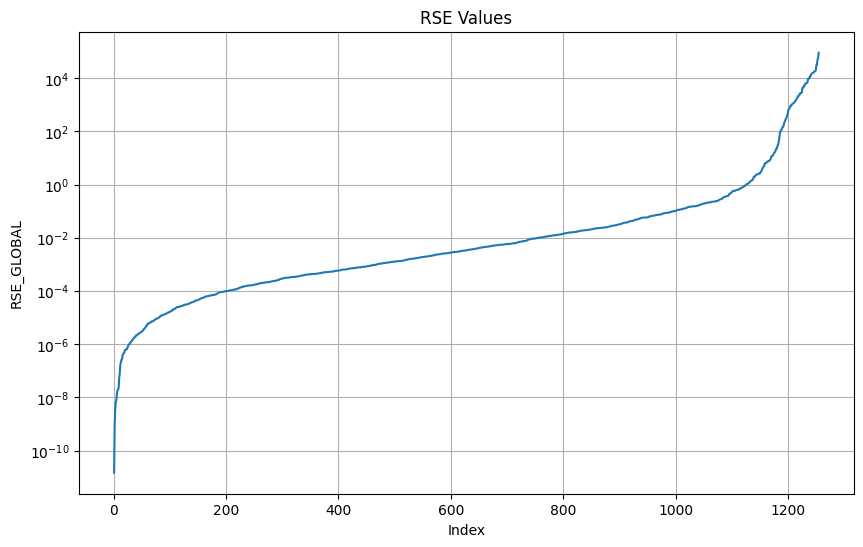

In [100]:
# Indexing 
windowSpec = Window.orderBy("RSE_GLOBAL")

data = df_global_ex_events.withColumn("Index", F.row_number().over(windowSpec))\
                          .select("Index", "RSE_GLOBAL")\
                          .rdd.map(lambda row: (row["Index"], row["RSE_GLOBAL"]))\
                          .collect()

indexes, rse_values = zip(*data)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(indexes, rse_values)
plt.title('RSE Values')
plt.xlabel('Index')
plt.ylabel('RSE_GLOBAL')
plt.yscale('log')
plt.grid(True)
plt.show()

In [101]:
def plot_selected(indexes):
    
    groups_to_plot = df_global_ex.select('INTERVAL', 'RSE_GLOBAL').distinct().orderBy('RSE_GLOBAL', ascending=True).collect()
    
    for i in indexes:
        interval = groups_to_plot[i]
        plot_glob(df_global_ex[df_global_ex.INTERVAL == interval['INTERVAL']].toPandas(), islocal = False)

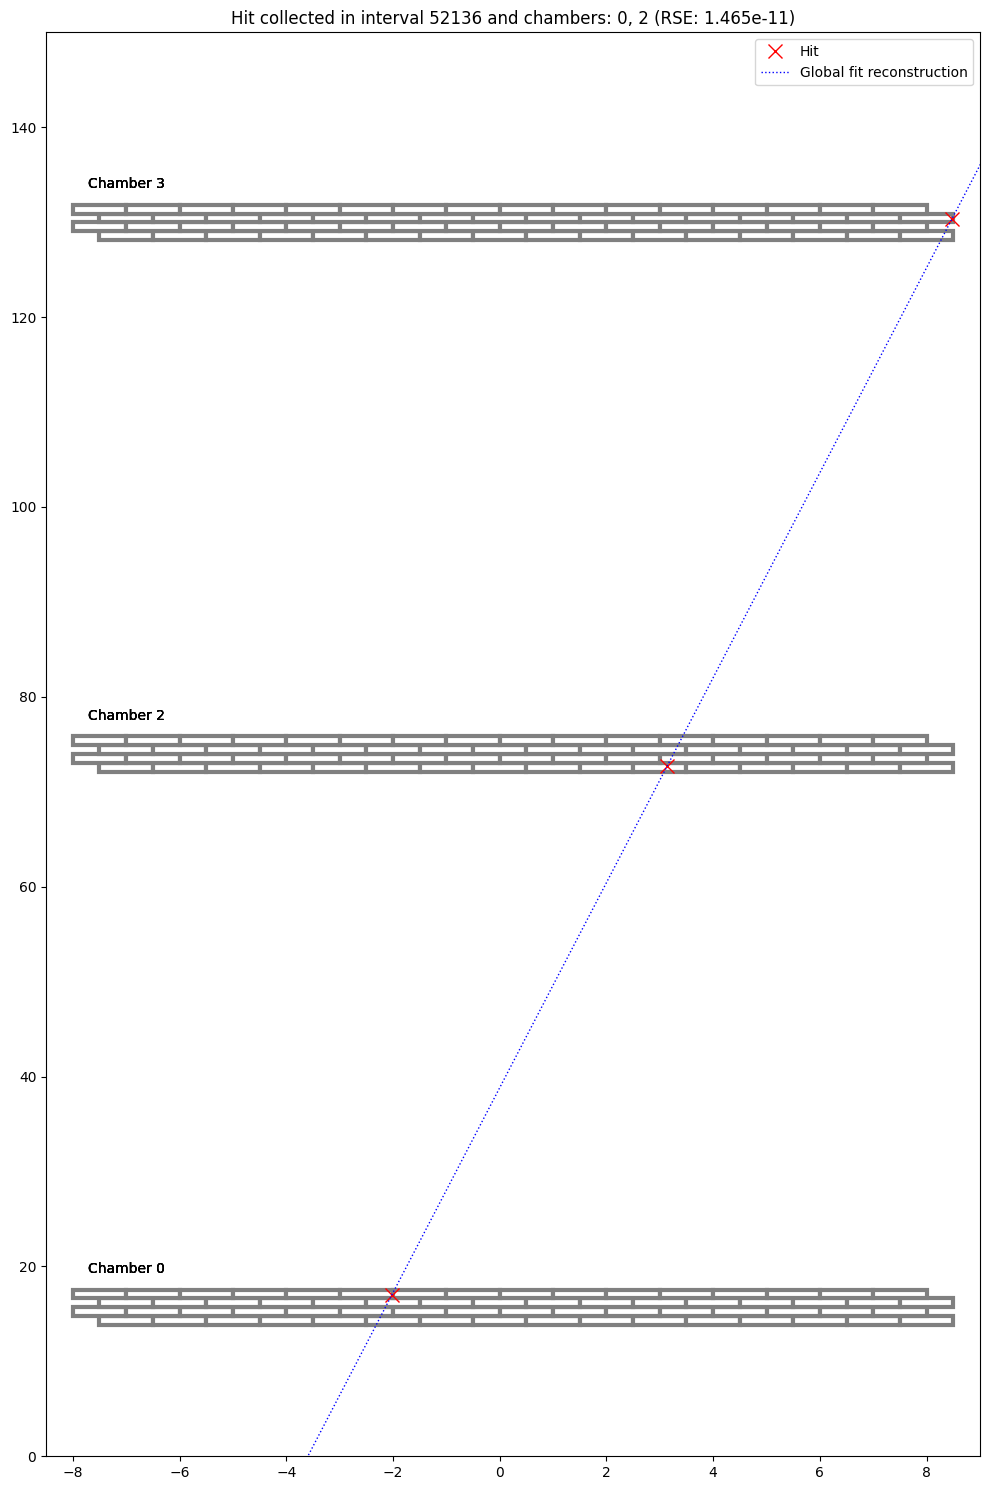

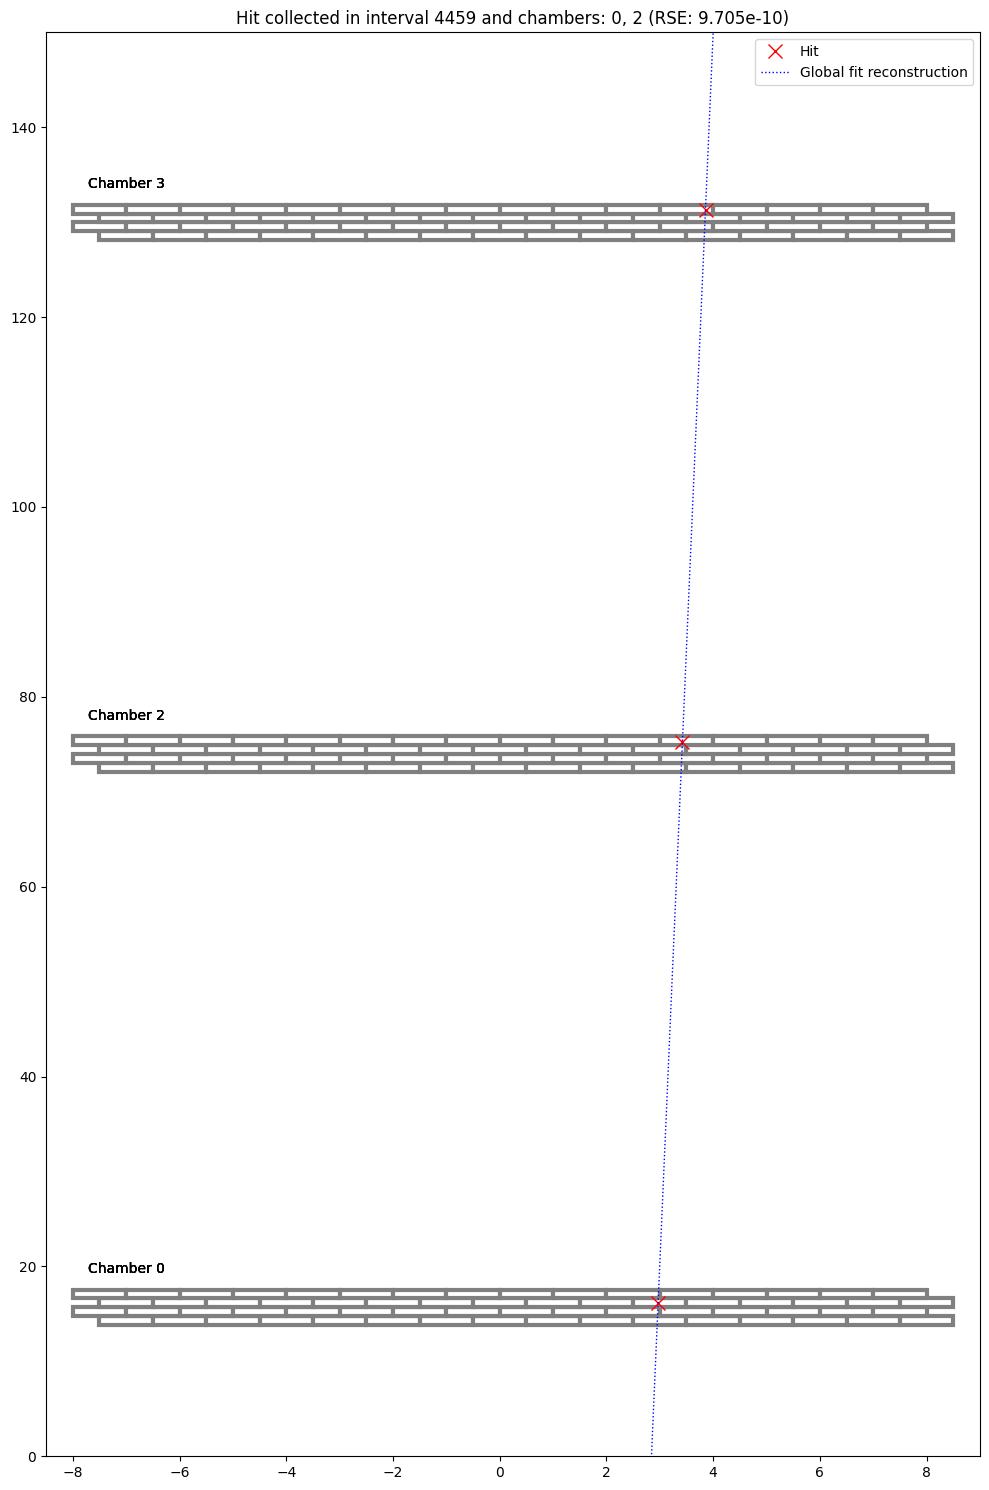

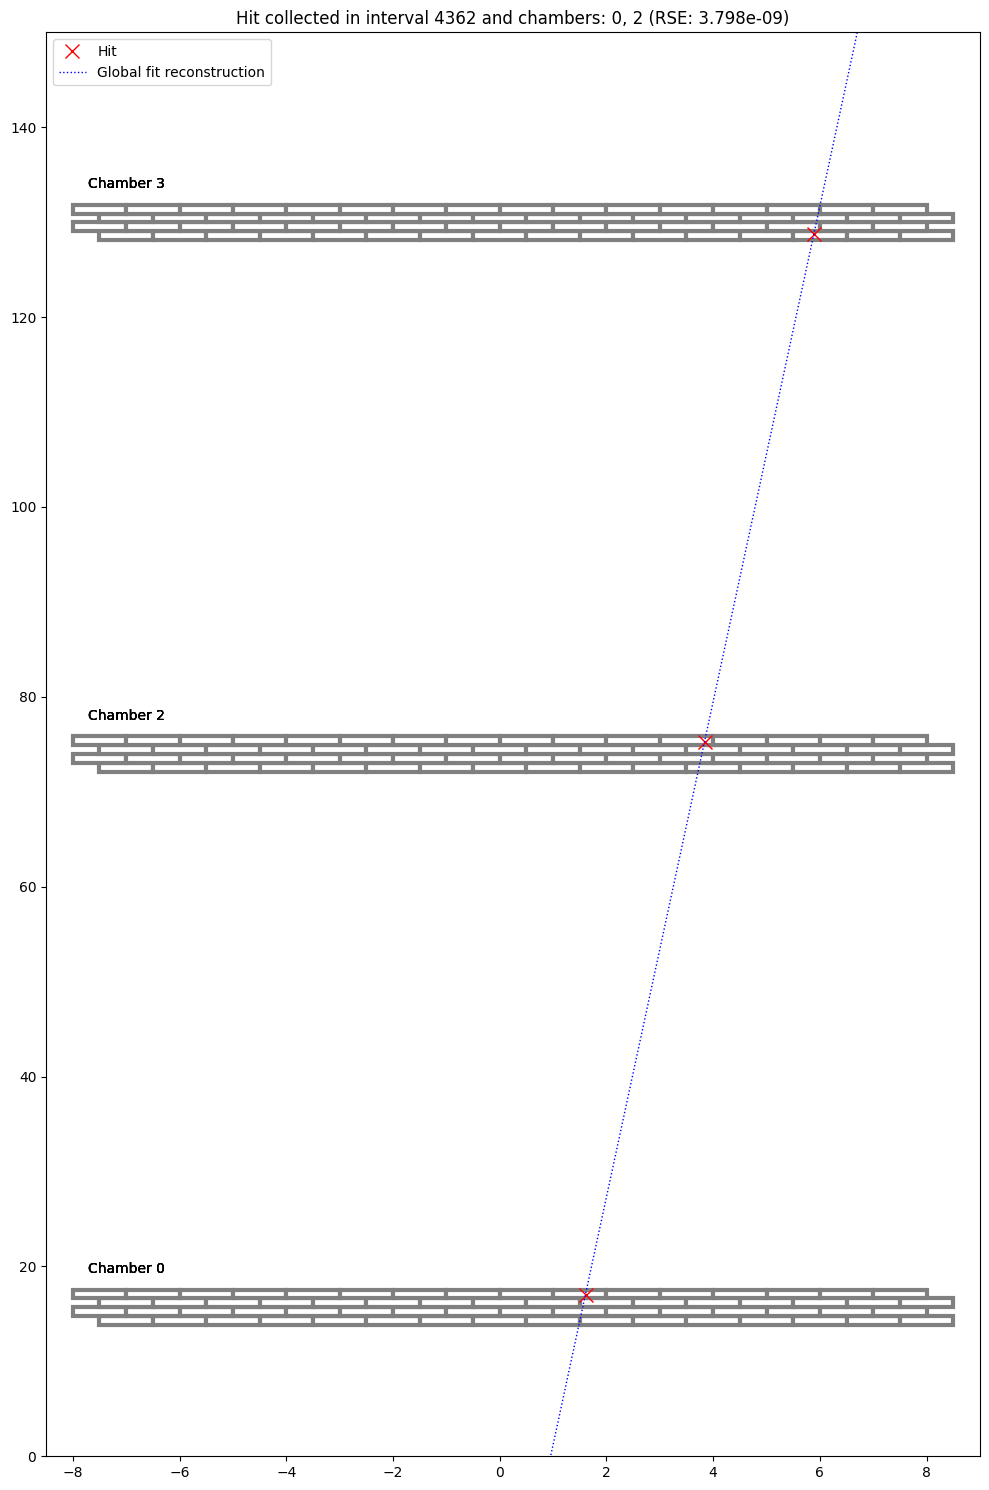

24/09/07 21:06:41 ERROR TaskSchedulerImpl: Lost executor 0 on 10.67.22.62: Command exited with code 137


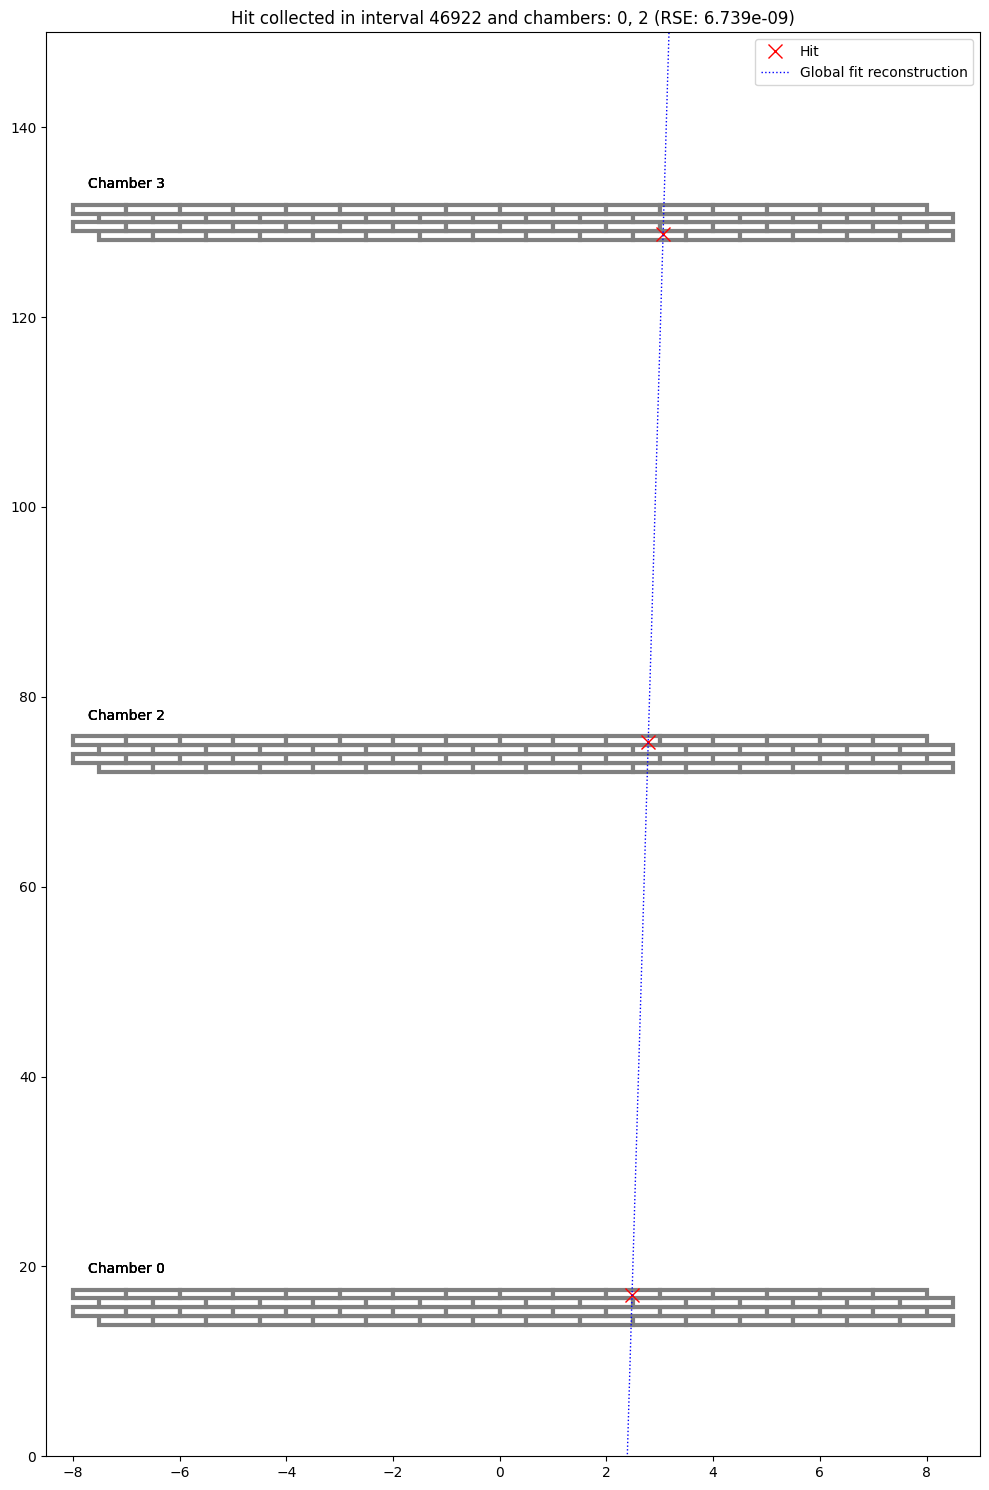

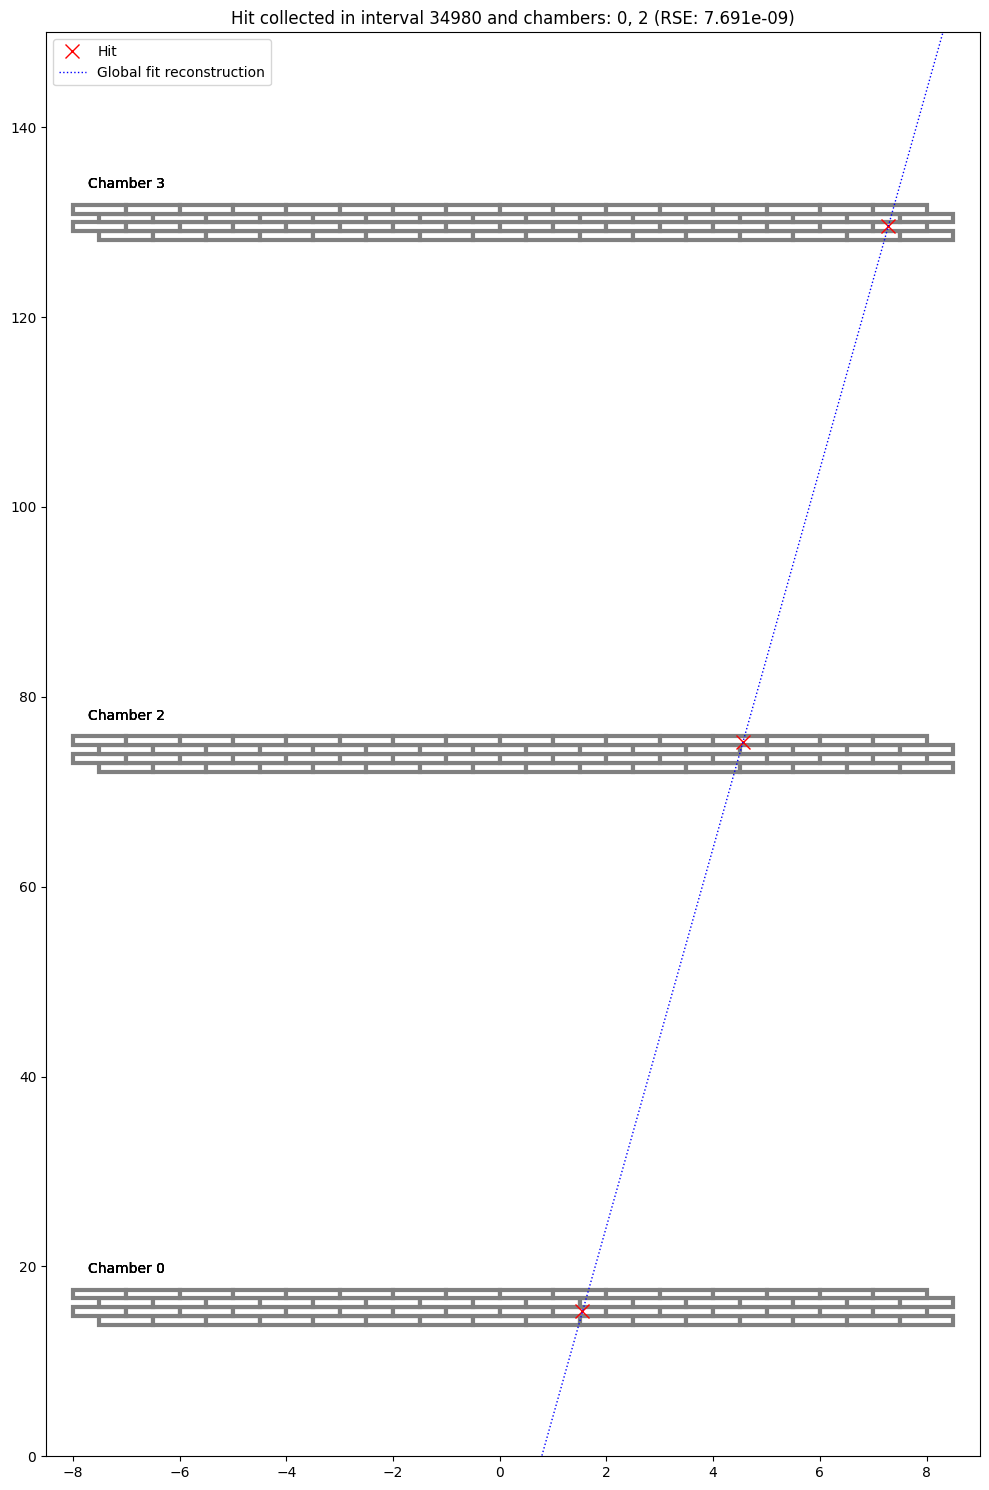

In [102]:
plot_selected([i for i in range(5)])

In [109]:
df_global_ex_events.filter(col("EVENTS") != 3).show(20)

+--------+----------+------+
|INTERVAL|RSE_GLOBAL|EVENTS|
+--------+----------+------+
+--------+----------+------+



24/09/07 22:33:26 ERROR TaskSchedulerImpl: Lost executor 1 on 10.67.22.96: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
24/09/07 22:33:59 ERROR TaskSchedulerImpl: Lost executor 3 on 10.67.22.250: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
24/09/07 22:35:11 ERROR TaskSchedulerImpl: Lost executor 1496487 on 10.67.22.62: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


## Detector angular resolution

As suggested by the guidelines, in order to provide an estimate of the angular resolution of the detector we can inspect the angular difference between the local fit in the chamber $2$ and the global fit for the same event. We expect those differences to distribute as a normal curve around zero (assuming there are no bias for the left or for the right).

In [ ]:
df_global = df_global.withColumnRenamed("M", "M_RENAMED")

df_angles = df_local.filter(col("CHAMBER") == 2)\
                    .join(df_global, on = "INTERVAL", how = "inner")\
                    .select("INTERVAL", "M", "M_GLOBAL")

df_angles = df_angles.withColumn("ANGLE", atan(F.col("M"))) \
                     .withColumn("ANGLE_GLOBAL", atan(F.col("M_GLOBAL"))) \
                     .withColumn("ANGLE_DIFF", (F.col("ANGLE") - F.col("ANGLE_GLOBAL")) * 1000)

df_angles = df_angles.drop("M", "M_GLOBAL")

df_angles.show(10)

Let's explore our data. First of all we are interested into the minimum and maximum value of the angular difference.

In [ ]:
angle_diff = df_angles.rdd.map(lambda row: (row["ANGLE_DIFF"])).collect()

print("Minimum value of angular difference: ", min(angle_diff))
print("Maximum value of angular difference: ", max(angle_diff))

They seem to be quite high values. We choose to plot the histogram of the angular difference whose absolute value is greater than a given value, say $100$.

In [ ]:
diff_100 = [angle for angle in angle_diff if abs(angle) > 100]

plt.figure(figsize = (10, 6))
plt.hist(diff_100, bins = 250, edgecolor = 'black', alpha = 0.7, density = True)
plt.title('Distribution of the differences of angles')
plt.xlabel('Difference of angles (milli-radians)')
plt.ylabel('Frequency')
plt.xlim(min(diff_100), max(diff_100))
plt.show()

We can clearly see some values around zero, as we would expect from our gaussian distribution, but we also observe some outliers around the values $-3000$ and $3000$. We suspect that there are cases where the local fit line has a slight slope to the left, while the global fit line has a slight slope to the right; in fact, if that is the case, we would have an angle $\sim\frac{\pi}{2}$ for one fit and an angle $\sim-\frac{\pi}{2}$ for the other fit, so the difference would give us

$$\left(\sim\frac{\pi}{2}\right)-\left(\sim-\frac{\pi}{2}\right)=\sim\pi$$

or the opposite ($\sim-\pi$) if the the angles are swapped in the difference.

We then re-evaluate these angular differences considering only the actual angle between the lines.

In [ ]:
new_angle_diff = (np.pi/2 - F.abs(F.col("ANGLE"))) - (np.pi/2 - F.abs(F.col("ANGLE_GLOBAL")))
condition = F.abs(F.col("ANGLE_DIFF")) > 2500

df_angles_new = df_angles.withColumn("ANGLE_DIFF", F.when(condition, new_angle_diff).otherwise(F.col("ANGLE_DIFF")))

Let's re-evaluate the maximum and minimum angular difference.

In [ ]:
angle_diff = df_angles_new.rdd.map(lambda row: (row["ANGLE_DIFF"])).collect()

print("Minimum value of angular difference: ", min(angle_diff))
print("Maximum value of angular difference: ", max(angle_diff))

We can now make a gaussian fit with the function `stats.norm.fit()` from the `scipy` package.

In [ ]:
mu, s = stats.norm.fit(angle_diff)
p = stats.norm.pdf(np.linspace(min(angle_diff), max(angle_diff), 1000), mu, s)

plt.figure(figsize = (10, 6))
plt.hist(angle_diff, bins = 250, edgecolor = 'black', alpha = 0.7, density = True)
plt.title('Distribution of the differences of angles')
plt.xlabel('Difference of angles (milliradians)')
plt.ylabel('Frequency')
plt.xlim(min(angle_diff), max(angle_diff))

plt.plot(np.linspace(min(angle_diff), max(angle_diff), 1000), p, 'red', label = 'Gaussian fit')
print(f"Mean = {mu}")
print(f"Standard deviation = {s}")

plt.grid(True)
plt.legend()
plt.show()

Data follows what expected, even though angular differences are not actually centered in the value $0$, but they are still very close ($1.16 \ mrad$). Of course, we cannot be very accurate since we miss some valuable information (error on the chamber hit time, error on the scintillator hit time and so on), but we can say that the angular resolution is strongly related to the standard deviation of the curve that fits our histogram. Hence, our estimated angular resolution $\sigma\simeq27.90 \ mrad$, which corresponds to $\sim1.60°$.

In [ ]:
'''
write_time(f"{time.time() - start_time}")
'''

In [ ]:
'''
file.close()
'''

In [ ]:
sc.stop()
spark.stop()